In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from math import ceil
import shelve
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.base import BaseEstimator, ClassifierMixin
from itertools import combinations

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.svm import SVC

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.callbacks import EarlyStopping

from inspector.app.utils import get_feature_values
from inspector.app.utils.model import Model
from inspector.app.views import gather_values

import re
from gensim.models.word2vec import Word2Vec

SEED = 25

In [9]:
df = pd.read_csv(r'D:\hse_iot\VKR\my_inspector\data\classification_dataset.csv')
df['class'] = round(df['class'] / 10).astype(int)
df = df[df['class'] != 1]
_type = df['type'].to_list()
df = df.drop(['name', 'side_mistake',
              'vs', 'squared_vs', 'ttr', 'root_ttr',
              'log_ttr', 'uber_ttr', 'd', 'vvi',
              'squared_vv', 'punct_mistakes_pp',
              'punct_mistakes_because',
              'punct_mistakes_but', 'punct_mistakes_compare'], axis=1)

df.head(2)

,av_depth,max_depth,min_depth,num_acl,num_rel_cl,num_advcl,num_sent,num_tok,av_tok_before_root,av_len_sent,...,num_linkings,num_4grams,num_func_ngrams,num_shell_noun,num_misspelled_tokens,million_mistake,text,class,type,sum_punct
0,3.56,6,2,2,0,1,18,244,4.39,13.56,...,5,1,0,0,2,0,This two line graphs illustrates monthly avera...,6,1,0
1,5.43,10,4,1,3,1,7,175,6.29,25.00,...,6,1,0,0,3,0,"﻿We have two graphics, which show us the popul...",6,1,0


In [10]:
df['class'].value_counts()

6    2680
7     308
5     215
4     122
8      77
2      24
3      14
Name: class, dtype: int64

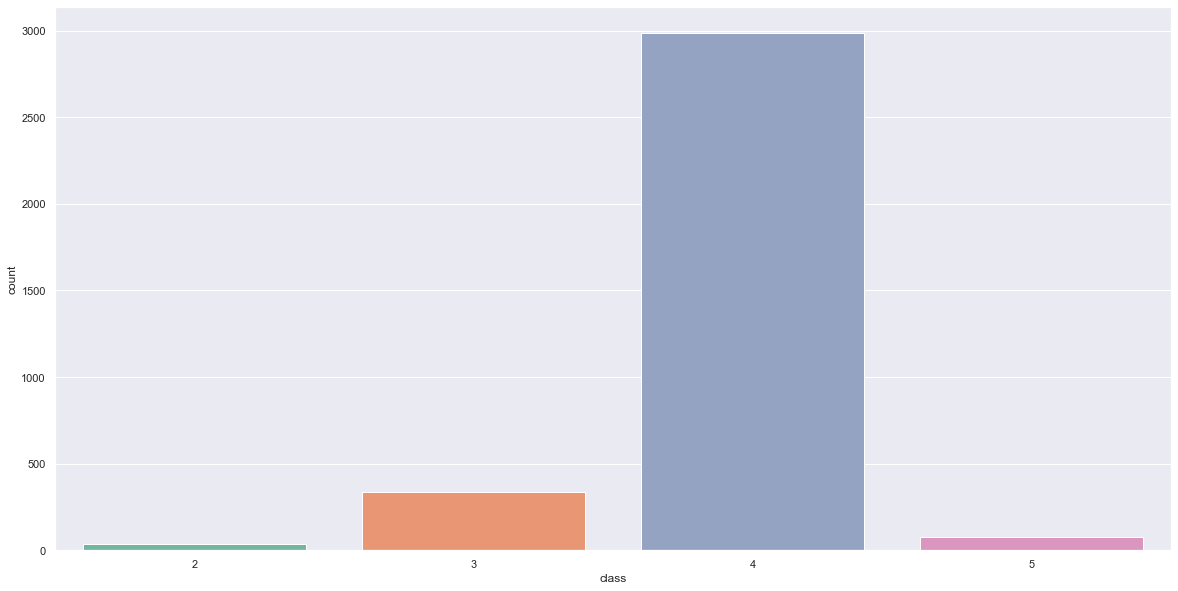

In [11]:
df.loc[df['class'] == 1, 'class'] = 2
df.loc[df['class'] == 3, 'class'] = 2
df.loc[df['class'] == 4, 'class'] = 3
df.loc[df['class'] == 5, 'class'] = 3
df.loc[df['class'] == 6, 'class'] = 4
df.loc[df['class'] == 7, 'class'] = 4
df.loc[df['class'] == 8, 'class'] = 5

sns.set(rc={'figure.figsize':(20,10)})
sns_plt = sns.countplot(x='class', data=df, palette="Set2")

Т.к. имеем очень малое количество текстов во всех классах кроме 4, то сгенерируем тексты скомпоновав их половины

In [12]:
df_gen = pd.read_csv(r'D:\hse_iot\VKR\my_inspector\data\generated_data.csv', index_col='idx')
df_gen.drop(['squared_vs', 'root_ttr', 'uber_ttr', 'ttr', 'd', 'vvi', 'squared_vv', 'vs', 'log_ttr'],  inplace=True, axis=1)
df_gen.head(2)

,av_depth,max_depth,min_depth,num_acl,num_rel_cl,num_advcl,num_sent,num_tok,av_tok_before_root,av_len_sent,...,num_pres_plur,num_past_part,num_past_simple,num_linkings,num_4grams,num_func_ngrams,million_mistake,text,sum_punct,cls
idx,,,,,,,,,,,,,,,,,,,,,
0,3.69,7,2,2,2,0,13,189,4.23,14.54,...,0,2,4,6,3,1,0,The graph illustrates the market situation abo...,0,4
1,3.93,7,2,1,3,1,15,244,4.80,16.27,...,0,3,0,13,2,0,0,There is a linegraph and piechart. The linegra...,0,4


In [13]:
df_gen['cls'].value_counts()

5    2441
4    2386
3    2257
2    2016
Name: cls, dtype: int64

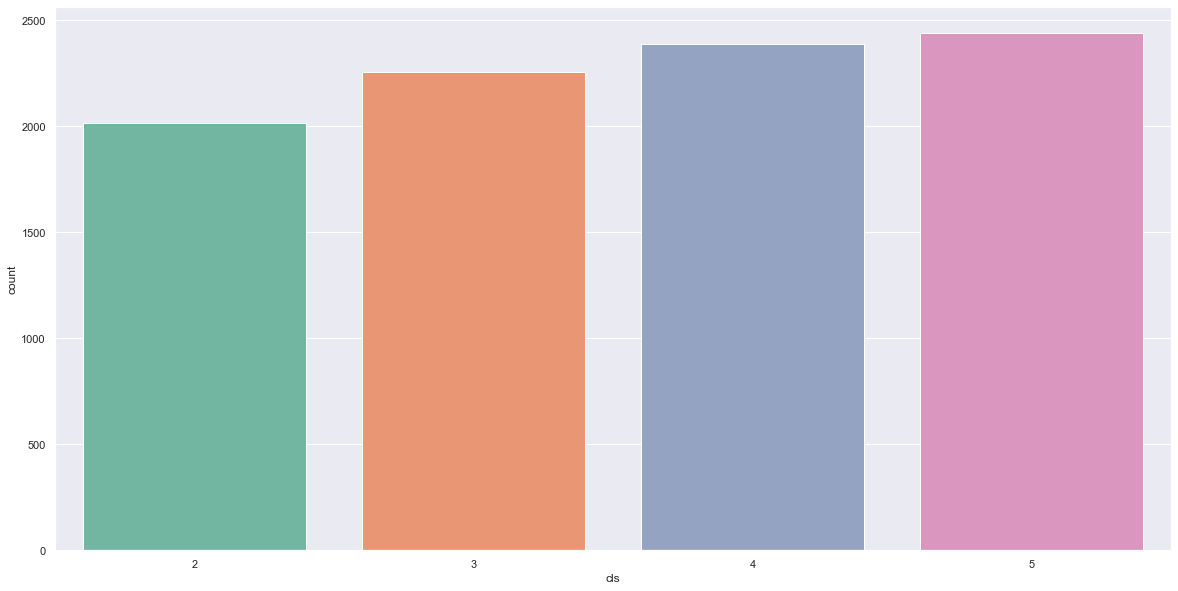

In [14]:
sns.set(rc={'figure.figsize':(20,10)})
sns_plt = sns.countplot(x='cls', data=df_gen, palette="Set2")

Данные тексты сгенерированы только из тренировочных данных, тестовые оставим неизменными в качестве выборки валидации

In [88]:
class Results:
    def __init__(self, train_data, test_x, test_y, w2v_path='data\\w2v'):
        self.texts = train_data['text'].copy()
        self.train_y = train_data['cls'].copy()
        self.feature_columns = [col for col in train_data.columns if col not in ['cls', 'text']]
        self.train_x = train_data[self.feature_columns].copy()
        self.test_x = test_x[self.feature_columns].copy()
        self.test_y = test_y
        
        with shelve.open(w2v_path, flag='r') as w2v_file:
            self.w2v = w2v_file['w2v']
        self.index2word_set = set(self.w2v.wv.index2word)
        
        w2v_vectors = [self.text_to_vec(text) for text in self.texts]
        w2v_vectors_df = pd.DataFrame([i for i in w2v_vectors], columns=['w2v_' + str(i) for i in range(w2v_vectors[0].shape[0])])
        w2v_vectors_df.index = self.train_x.index
        self.train_x = pd.merge(self.train_x, w2v_vectors_df, right_index=True, left_index=True)
        
        w2v_vectors = [self.text_to_vec(text) for text in test_x.text]
        w2v_vectors_df = pd.DataFrame([i for i in w2v_vectors], columns=['w2v_' + str(i) for i in range(w2v_vectors[0].shape[0])])
        w2v_vectors_df.index = self.test_x.index
        self.test_x = pd.merge(self.test_x, w2v_vectors_df, right_index=True, left_index=True)
        
        # классы для нейронных сетей
        self.train_y_nn = self.ohe(self.train_y)
        self.test_y_nn = self.ohe(self.test_y)
        
        self.nn_scorer = make_scorer(self.custom_scorer, greater_is_better=True)
        
        # Изменение размерности входных данных для сверточных нейросетей
        train_x2 = np.array(self.train_x)
        test_x2 = np.array(self.test_x)
        #self.train_x_cnv = train_x2.reshape(-1, 57, 1)
        #self.test_x_cnv = test_x2.reshape(-1, 57, 1)
    
    def text_to_words(self, text):
        model = Model(r'D:\hse_iot\VKR\my_inspector\inspector\app\data\models\english-partut-ud-2.3-181115.udpipe')
        gf = get_feature_values.GetFeatures(model)
        gf.get_info(text)
        
        words = []
        for sent in gf.sentences:
            sent_list = []
            for word in sent:
                lemma = word.get('lemma')
                if re.sub('[^a-zA-Zа-яА-яёЁ]', '', lemma) != '':
                    sent_list.append(lemma)
            words.extend(sent_list)
        return words
    
    def text_to_vec(self, text):
        text_vec = np.zeros((self.w2v.vector_size,), dtype="float32")
        n_words = 0
        
        for word in self.text_to_words(text):
            if word in self.index2word_set:
                n_words = n_words + 1
                text_vec = np.add(text_vec, self.w2v[word]) 
        
        if n_words != 0:
            text_vec /= n_words
        return text_vec

    
    def ohe(self, y):
        y_nn = []
        for y in y:
            dummy = np.zeros(4)
            y = y - 2
            dummy[y] = 1
            y_nn.append(dummy)
        return np.array(y_nn)
    
    def re_ohe(self, y):
        dummy = np.array([np.argmax(i) for i in y])
        return dummy + 2
    
    def custom_scorer(self, y_true_nn, y_pred):
        y_true = self.re_ohe(y_true_nn)
        y_pred += 2
        return accuracy_score(y_true, y_pred)
    
    def show_train_data(self):
        fig, ax = plt.subplots(1, 1)
        fig.set_size_inches(10,8)
        plt.tick_params(labelsize=15)
        
        ax = sns.countplot(x='cls', data=pd.DataFrame(self.train_y), palette="Set2")
        ax.set_xlabel('Классы', {'fontsize': 15})
        ax.set_ylabel('Кол-во текстов', {'fontsize': 15})
        ax.grid(True)
        ax.set_title('Распределение классов', {'fontsize': 20})
        
        plt.show()
    
    # Добавить модель к классу
    # (модель, сетка для 1 раунда, сетка для 2 раунда)
    def add_est(self,
                name,
                est):
        setattr(self, 'est_{}'.format(name), {'est': est})
        
    # Установить параметр модели
    def set_est_param(self, est_name, param_name, param_value):
        dummy = getattr(self, 'est_{}'.format(est_name))
        dummy[param_name] = param_value
        setattr(self, 'est_{}'.format(est_name), dummy)
    
    def set_est_param_grid_1(self, est_name, param_grid_1):
        self.set_est_param(est_name, 'param_grid_1', param_grid_1)
        
    def set_est_param_grid_2(self, est_name, param_grid_2):
        self.set_est_param(est_name, 'param_grid_2', param_grid_2)
    
    def get_est_info(self, est_name):
        dummy = getattr(self, 'est_{}'.format(est_name))
        for key in dummy:
            print('{0}: {1}'.format(key, dummy.get(key)))
    
    # Получить список имен моделей
    def get_est_list(self):
        res = []
        for key in self.__dict__.keys():
            if key.startswith('est_'):
                res.append(key.replace('est_', ''))
        return res
    
    # Сохранить модели в файл
    def load_estimators(self, file_name):
        with shelve.open('data\\{}'.format(file_name), flag='r') as df:
            for est_name in df:
                setattr(self, 'est_{}'.format(est_name), df[est_name])
    
    # Загрузить модели из файла
    def save_estimators(self, file_name):
        with shelve.open('data\\{}'.format(file_name), flag='n') as df:
            for est_name in self.get_est_list():
                df[est_name] = getattr(self, 'est_{}'.format(est_name))
        
    # Первый раунд обучения модели
    def first_round_search(self, est_name, num_iter=100, cv=3, train_x = None, plot=True):
        est = getattr(self, 'est_{}'.format(est_name)).get('est')
        param_grid = getattr(self, 'est_{}'.format(est_name)).get('param_grid_1')
        if not train_x:
            train_x = self.train_x
        grid = RandomizedSearchCV(estimator=est,
                          param_distributions=param_grid,
                          n_iter = num_iter,
                          scoring='accuracy',
                          n_jobs=-1,
                          verbose=1,
                          cv=cv,
                          random_state=SEED)
        grid_result = grid.fit(train_x, self.train_y)
        if plot:
            rs_df = pd.DataFrame(grid_result.cv_results_).sort_values('rank_test_score').reset_index(drop=True)
            rs_df = rs_df.drop([
                'mean_fit_time', 
                'std_fit_time', 
                'mean_score_time',
                'std_score_time', 
                'params',
                'std_test_score'],
                axis=1)
            params_labels = [param for param in rs_df.columns if 'param' in param]
    
            cols = ceil(np.sqrt(len(params_labels)))
            lines = ceil(len(params_labels)/cols)
            fig, axs = plt.subplots(ncols=cols, nrows=lines)
            sns.set(style="whitegrid", color_codes=True, font_scale = 2)
            fig.set_size_inches(30,30)
    
            col = 0
            line = 0
            for param in params_labels:
                sns.barplot(x=param, y='mean_test_score', data=rs_df, ax=axs[line, col])
                axs[line, col].set_ylim([rs_df.groupby(param).mean()['mean_test_score'].min()*0.95,
                                 rs_df.groupby(param).mean()['mean_test_score'].max()*1.05])
                axs[line, col].set_title(label = param.replace('param_', ''), size=25, weight='bold')
            
                axs[line, col].tick_params(labelsize=20)
            
                if col < cols - 1:
                    col += 1
                else:
                    line += 1
                    col = 0
        return grid_result.best_estimator_
    
    def first_round_search_nn(self, est_name, train_x, num_iter=100, cv=3):
        est = getattr(self, 'est_{}'.format(est_name)).get('est')
        param_grid = getattr(self, 'est_{}'.format(est_name)).get('param_grid_1')
        
        early_stopping_cac = EarlyStopping(monitor='categorical_accuracy', patience=5)
        grid = RandomizedSearchCV(estimator=est,
                               param_distributions=param_grid,
                               n_iter = num_iter,
                               scoring=self.nn_scorer,
                               verbose=1,
                               cv=cv,
                               n_jobs=-1)
        grid_result = grid.fit(train_x, self.train_y_nn, callbacks=early_stopping_cac)
        rs_df = pd.DataFrame(grid_result.cv_results_).sort_values('rank_test_score').reset_index(drop=True)
        rs_df = rs_df.drop([
            'mean_fit_time', 
            'std_fit_time', 
            'mean_score_time',
            'std_score_time', 
            'params',
            'std_test_score'],
            axis=1)
        params_labels = [param for param in rs_df.columns if 'param' in param]
    
        cols = ceil(np.sqrt(len(params_labels)))
        lines = ceil(len(params_labels)/cols)
        fig, axs = plt.subplots(ncols=cols, nrows=lines)
        sns.set(style="whitegrid", color_codes=True, font_scale = 2)
        fig.set_size_inches(30,30)
    
        col = 0
        line = 0
        for param in params_labels:
            sns.barplot(x=param, y='mean_test_score', data=rs_df, ax=axs[line, col])
            axs[line, col].set_ylim([rs_df.groupby(param).mean()['mean_test_score'].min()*0.95,
                                 rs_df.groupby(param).mean()['mean_test_score'].max()*1.05])
            axs[line, col].set_title(label = param.replace('param_', ''), size=25, weight='bold')
        
            axs[line, col].tick_params(labelsize=20)
            
            if col < cols - 1:
                col += 1
            else:
                line += 1
                col = 0
        
    # Второй раунд обучения
    def second_round_search(self, est_name, cv=3):
        est = getattr(self, 'est_{}'.format(est_name)).get('est')
        param_grid = getattr(self, 'est_{}'.format(est_name)).get('param_grid_2')
        
        grid = GridSearchCV(estimator=est,
                            param_grid=param_grid,
                            scoring='accuracy',
                            n_jobs=-1,
                            verbose=1,
                            cv=cv)
        grid_result = grid.fit(self.train_x, self.train_y)
        
        self.set_est_param(est_name, 'train_acc', grid_result.best_score_)
        self.set_est_param(est_name, 'best_params', grid_result.best_params_)
        self.set_est_param(est_name, 'best_est', grid_result.best_estimator_)
        
        (test_acc, cm, pred_y) = self.est_res(est_name)
        self.set_est_param(est_name, 'test_acc', test_acc)
        self.set_est_param(est_name, 'confusion_matrix', cm)
        self.set_est_param(est_name, '{}_pred_y'.format(est_name), pred_y)
        
    def second_round_search_nn(self, est_name, train_x, cv=3):
        est = getattr(self, 'est_{}'.format(est_name)).get('est')
        param_grid = getattr(self, 'est_{}'.format(est_name)).get('param_grid_2')
        
        early_stopping_ac = EarlyStopping(monitor='accuracy', patience=5)
        early_stopping_cac = EarlyStopping(monitor='categorical_accuracy', patience=5)
        
        grid = GridSearchCV(estimator=est,
                            param_grid=param_grid,
                            scoring=self.nn_scorer,
                            n_jobs=-1,
                            verbose=1,
                            cv=cv)
        grid_result = grid.fit(train_x, self.train_y_nn, callbacks=[early_stopping_ac, early_stopping_cac])
        
        self.set_est_param(est_name, 'train_acc', grid_result.best_score_)
        self.set_est_param(est_name, 'best_params', grid_result.best_params_)
        self.set_est_param(est_name, 'best_est', grid_result.best_estimator_)
        
        if est_name.startswith('cnv'):
            (test_acc, cm, pred_y) = self.est_res_nn(est_name, self.test_x_cnv)
        else:
            (test_acc, cm, pred_y) = self.est_res_nn(est_name, self.test_x)
        self.set_est_param(est_name, 'test_acc', test_acc)
        self.set_est_param(est_name, 'confusion_matrix', cm)
        self.set_est_param(est_name, '{}_pred_y'.format(est_name), pred_y)
    
    def est_res(self, est_name):
        est = getattr(self, 'est_{}'.format(est_name)).get('best_est')
        
        pred_y = est.predict(self.test_x)
        cm = confusion_matrix(self.test_y, pred_y)
        acc = accuracy_score(self.test_y, pred_y)
        
        print('Accuracy: ', acc, '\n')
        print('Confusion matrix: \n', cm)
        
        return acc, cm, pred_y
    
    def est_res_nn(self, est_name, test_x):
        est = getattr(self, 'est_{}'.format(est_name)).get('best_est')
        
        pred_y = est.predict(test_x)
        pred_y += 2
        cm = confusion_matrix(self.test_y, pred_y)
        acc = accuracy_score(self.test_y, pred_y)
        
        print('Accuracy: ', acc, '\n')
        print('Confusion matrix: \n', cm)
        
        return acc, cm, pred_y
    
   
    def get_result_df(self):
        res = pd.DataFrame(self.test_y)
        res.rename(columns={'cls': 'real_y'}, inplace=True)
        
        for est_name in self.get_est_list():
            res['{}_y'.format(est_name)] = getattr(self, 'est_{}'.format(est_name)).get('{}_pred_y'.format(est_name))
        return res
    
    def umap_res(self, est, test_x, test_y):
        pred_y = est.predict(test_x)
        cm = confusion_matrix(test_y, pred_y)
        acc = accuracy_score(test_y, pred_y)
        
        class_list = test_y.value_counts().sort_index().index.to_list()
        real_cls_length = test_y.value_counts().sort_index().to_list()
        proc_acc = []
        for i in range(0, len(class_list)):
            proc_acc.append(round(cm[i,i]/real_cls_length[i], 2))
        
        return acc, proc_acc
    
    def umap(self, n_components, est_name):
        umap_reducer = umap.UMAP(n_components=n_components).fit(self.train_x)
        train_x = umap_reducer.transform(self.train_x)
        test_x = umap_reducer.transform(self.test_x)
        
        best_est = self.first_round_search(est_name, 100, train_x= train_x, plot=False)
        return self.umap_res(best_est, test_x, self.test_y)

In [19]:
df = df.rename(columns = {'class': 'cls'})
feature_columns = [col for col in df.columns if col not in ['cls',]]
X = df[feature_columns]
y = df['cls']
train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state = SEED)

In [20]:
train_data = train_x.copy()
train_data['cls'] = train_y

In [53]:
test_x.iloc[0].text

'It is a well known fact that people today have a lot of problems with their health because of the use of computers and other technologied devices. Some of this problems are very serious, some of them can be easily reduced. \r\n\r\nThe most common problem for people nowadays is the lack of mobility. We spend a great part of the day sitting by our computers. People who work sit near the computer almost 8 hours without even getting up. Even students who are supposed to be healthy and active suffer from this problem. To reduce this issue, special exercises brakes can be introduced in offices, maybe even in universities and schools. It is crucial to have some resting time during work and studying, but it’s also important for this break to be helpful physically and mentaly. And of course let’s not forget about the healthy diet a person should have and the importance of staying hidrated. \r\n\r\nAnother problem that is discussed a lot today is peoples’ dependence on mobile phones and the int

In [67]:
raw_data = Results(df_gen,
              test_x,
              test_y)

<ipython-input-66-e78a9b110e09>:58: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  text_vec = np.add(text_vec, self.w2v[word])


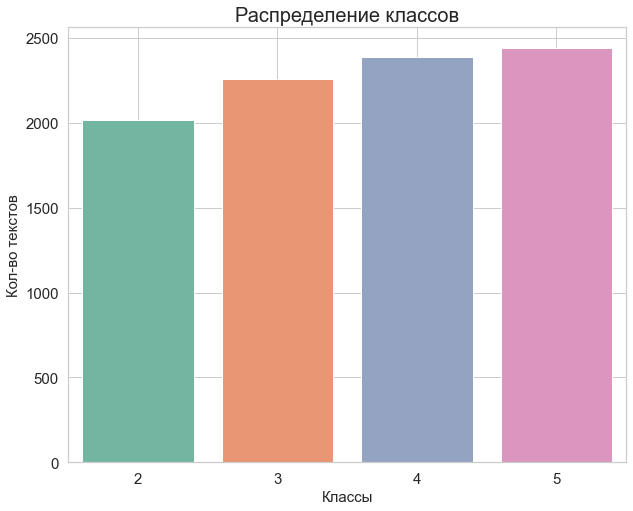

In [68]:
raw_data.show_train_data()

### knn

C:\Users\Konstantin\.conda\envs\ml_hse\lib\site-packages\sklearn\model_selection\_search.py:278: UserWarning: The total space of parameters 80 is smaller than n_iter=100. Running 80 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 3 folds for each of 80 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   32.7s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:  2.4min finished


KNeighborsClassifier(n_neighbors=6, p=1, weights='distance')

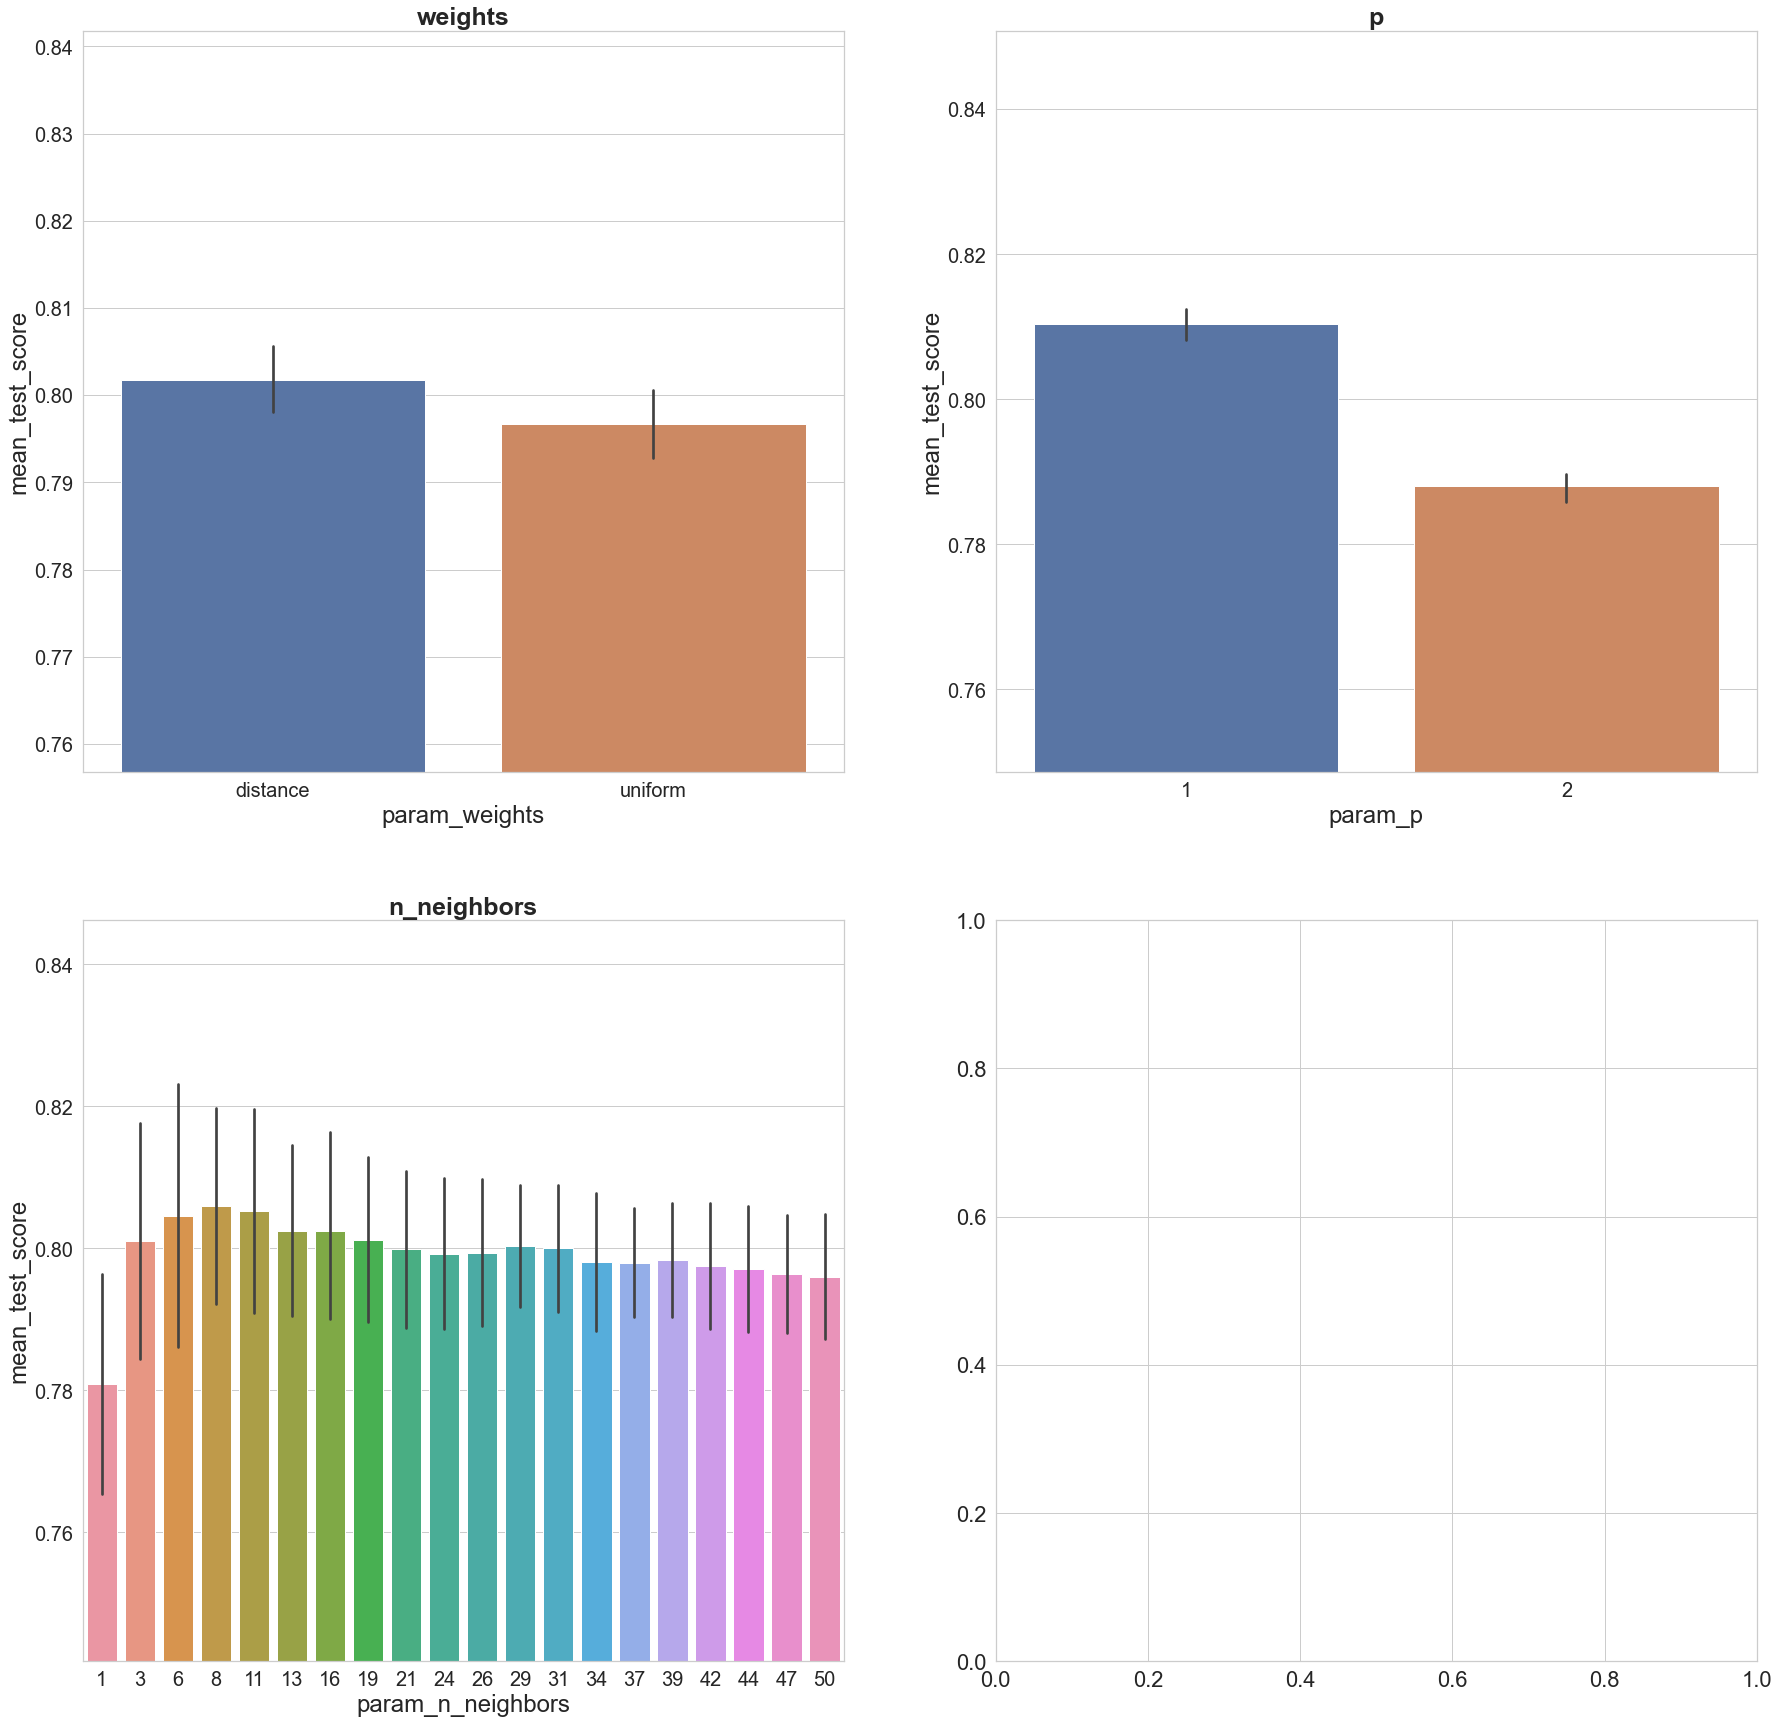

In [69]:
knn_param_grid_1 = {'n_neighbors': [int(x) for x in np.linspace(start = 1, stop = 50, num = 20)],
              'p': [1, 2],
              'weights': ['uniform', 'distance']}

raw_data.add_est('knn', KNeighborsClassifier(metric='minkowski', algorithm='auto'))
raw_data.set_est_param_grid_1('knn', knn_param_grid_1)

raw_data.first_round_search('knn', 100)

In [70]:
knn_param_grid_2 = {'n_neighbors': [7, 8, 9,],
              'p': [1,],
              'weights': ['distance',]}

raw_data.set_est_param_grid_2('knn', knn_param_grid_2)

In [71]:
raw_data.second_round_search('knn')

Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of   9 | elapsed:    6.0s remaining:    3.0s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:    6.1s finished


Accuracy:  0.9098837209302325 

Confusion matrix: 
 [[  2   3   3   0]
 [  4  38  34   0]
 [  0   5 581   1]
 [  0   0  12   5]]


In [72]:
raw_data.get_est_info('knn')

est: KNeighborsClassifier()
param_grid_1: {'n_neighbors': [1, 3, 6, 8, 11, 13, 16, 19, 21, 24, 26, 29, 31, 34, 37, 39, 42, 44, 47, 50], 'p': [1, 2], 'weights': ['uniform', 'distance']}
param_grid_2: {'n_neighbors': [7, 8, 9], 'p': [1], 'weights': ['distance']}
train_acc: 0.8233041972999996
best_params: {'n_neighbors': 7, 'p': 1, 'weights': 'distance'}
best_est: KNeighborsClassifier(n_neighbors=7, p=1, weights='distance')
test_acc: 0.9098837209302325
confusion_matrix: [[  2   3   3   0]
 [  4  38  34   0]
 [  0   5 581   1]
 [  0   0  12   5]]
knn_pred_y: [4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 3 4 4 4 3 4 3 4 4 4 4 4 3 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 3 4 4 4 4 4 4 4 4 4 4 3 4 4 4 4 4 4 3 4 4 4 4 4 4
 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 3 4 4 4 4 4 4 4 4 4 2 4 4 4 4 4 4 5 4 4 4 3 4 4 4 4 4 4 4 3
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 3 4 4 4 4 4 4 4 4 4 4 4 4 4 5 4 4 4 2

### RandomForest

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed: 10.7min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 17.2min finished


RandomForestClassifier(bootstrap=False, max_depth=30, max_features='log2',
                       min_samples_leaf=2, min_samples_split=8,
                       n_estimators=1000)

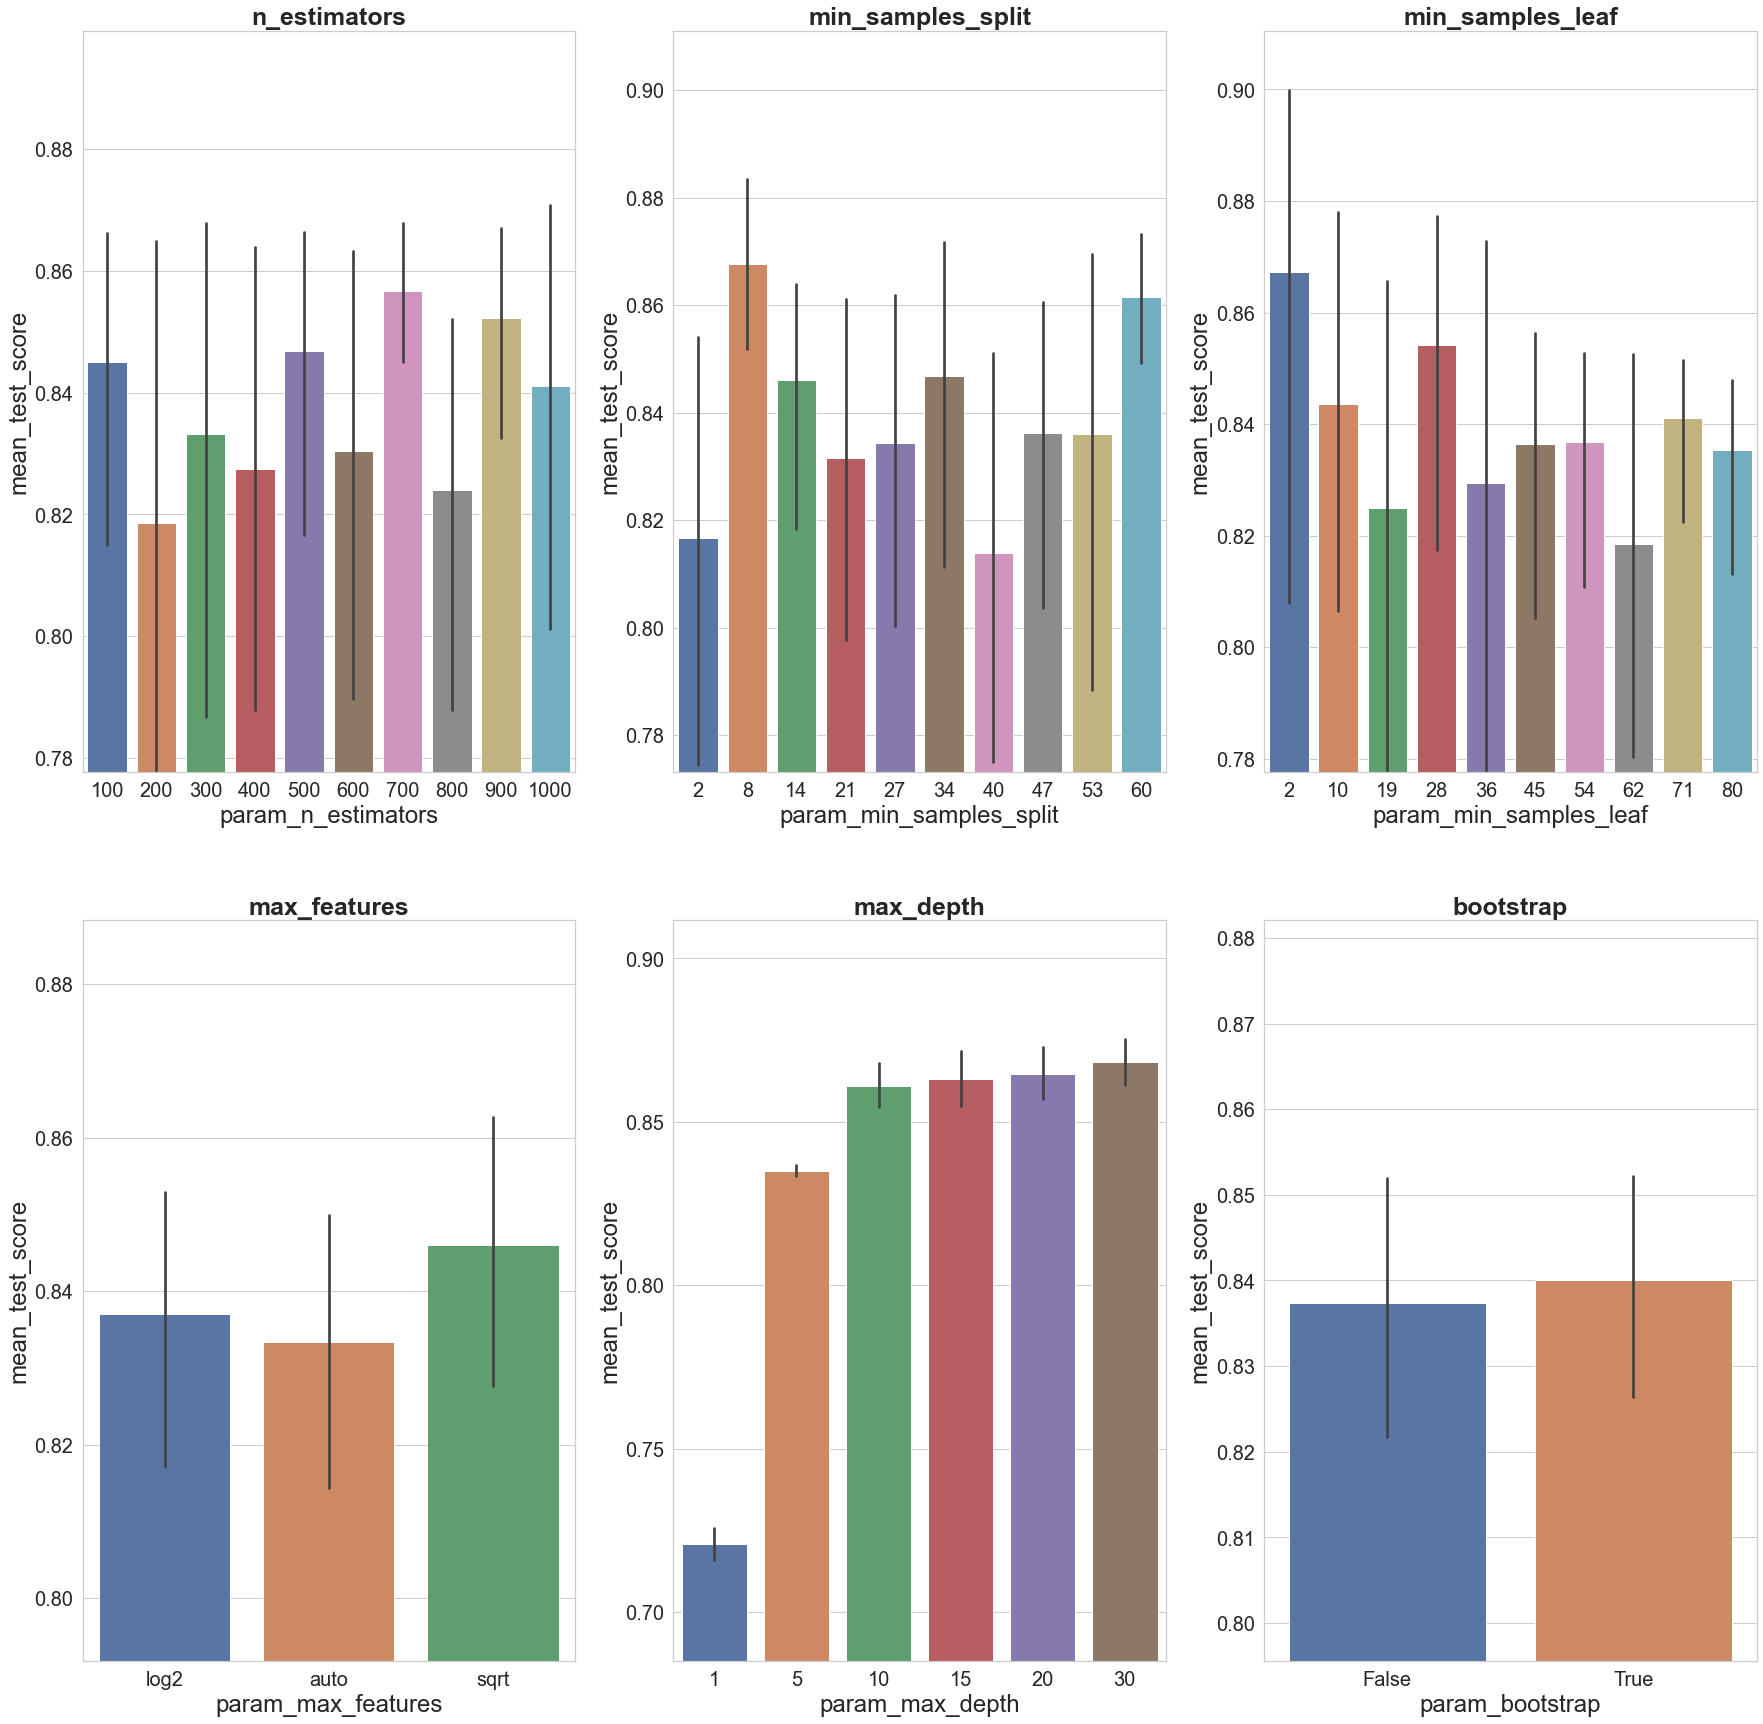

In [73]:
rf_param_grid_1 = {'n_estimators': [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)],
              'max_features': ['auto', 'log2', 'sqrt'],
              'max_depth': [1, 5, 10, 15, 20, 30],
              'min_samples_split': [int(x) for x in np.linspace(start = 2, stop = 60, num = 10)],
              'min_samples_leaf': [int(x) for x in np.linspace(start = 2, stop = 80, num = 10)],
              'bootstrap': [True, False]}

raw_data.add_est('rf', RandomForestClassifier())
raw_data.set_est_param_grid_1('rf', rf_param_grid_1)

raw_data.first_round_search('rf', 100)

In [74]:
rf_param_grid_2 = {'n_estimators': [int(x) for x in np.linspace(start = 680, stop = 780, num = 10)],
              'max_features': ['sqrt',],
              'max_depth': [29, 30, 31, 32, 33],
              'min_samples_split': [6, 7, 8],
              'min_samples_leaf': [1, 2, 3, 4],
              'bootstrap': [True,]}

raw_data.set_est_param_grid_2('rf', rf_param_grid_2)
raw_data.second_round_search('rf')

Fitting 3 folds for each of 600 candidates, totalling 1800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed: 21.1min
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed: 48.5min
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed: 88.7min
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed: 140.6min
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed: 203.6min
[Parallel(n_jobs=-1)]: Done 1800 out of 1800 | elapsed: 206.0min finished


Accuracy:  0.9026162790697675 

Confusion matrix: 
 [[  3   2   3   0]
 [  2  34  40   0]
 [  0   2 583   2]
 [  0   0  16   1]]


In [75]:
raw_data.get_est_info('rf')

est: RandomForestClassifier()
param_grid_1: {'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000], 'max_features': ['auto', 'log2', 'sqrt'], 'max_depth': [1, 5, 10, 15, 20, 30], 'min_samples_split': [2, 8, 14, 21, 27, 34, 40, 47, 53, 60], 'min_samples_leaf': [2, 10, 19, 28, 36, 45, 54, 62, 71, 80], 'bootstrap': [True, False]}
param_grid_2: {'n_estimators': [680, 691, 702, 713, 724, 735, 746, 757, 768, 780], 'max_features': ['sqrt'], 'max_depth': [29, 30, 31, 32, 33], 'min_samples_split': [6, 7, 8], 'min_samples_leaf': [1, 2, 3, 4], 'bootstrap': [True]}
train_acc: 0.9042955889232216
best_params: {'bootstrap': True, 'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 7, 'n_estimators': 768}
best_est: RandomForestClassifier(max_depth=30, max_features='sqrt', min_samples_split=7,
                       n_estimators=768)
test_acc: 0.9026162790697675
confusion_matrix: [[  3   2   3   0]
 [  2  34  40   0]
 [  0   2 583   2]
 [  0   0  16   1]]


### XGBoost

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed: 39.2min
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed: 174.4min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 277.0min finished
C:\Users\Konstantin\.conda\envs\ml_hse\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[03:14:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBRFClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                colsample_bytree=0.6, gamma=0.1, gpu_id=-1,
                importance_type='gain', interaction_constraints='',
                learning_rate=0.01, max_delta_step=0, max_depth=15,
                min_child_weight=1, missing=nan, monotone_constraints='()',
                n_estimators=300, n_jobs=12, num_parallel_tree=300,
                objective='multi:softprob', random_state=0, reg_alpha=0.01,
                reg_lambda=0.01, scale_pos_weight=None, subsample=1,
                tree_method='exact', validate_parameters=1, verbosity=None)

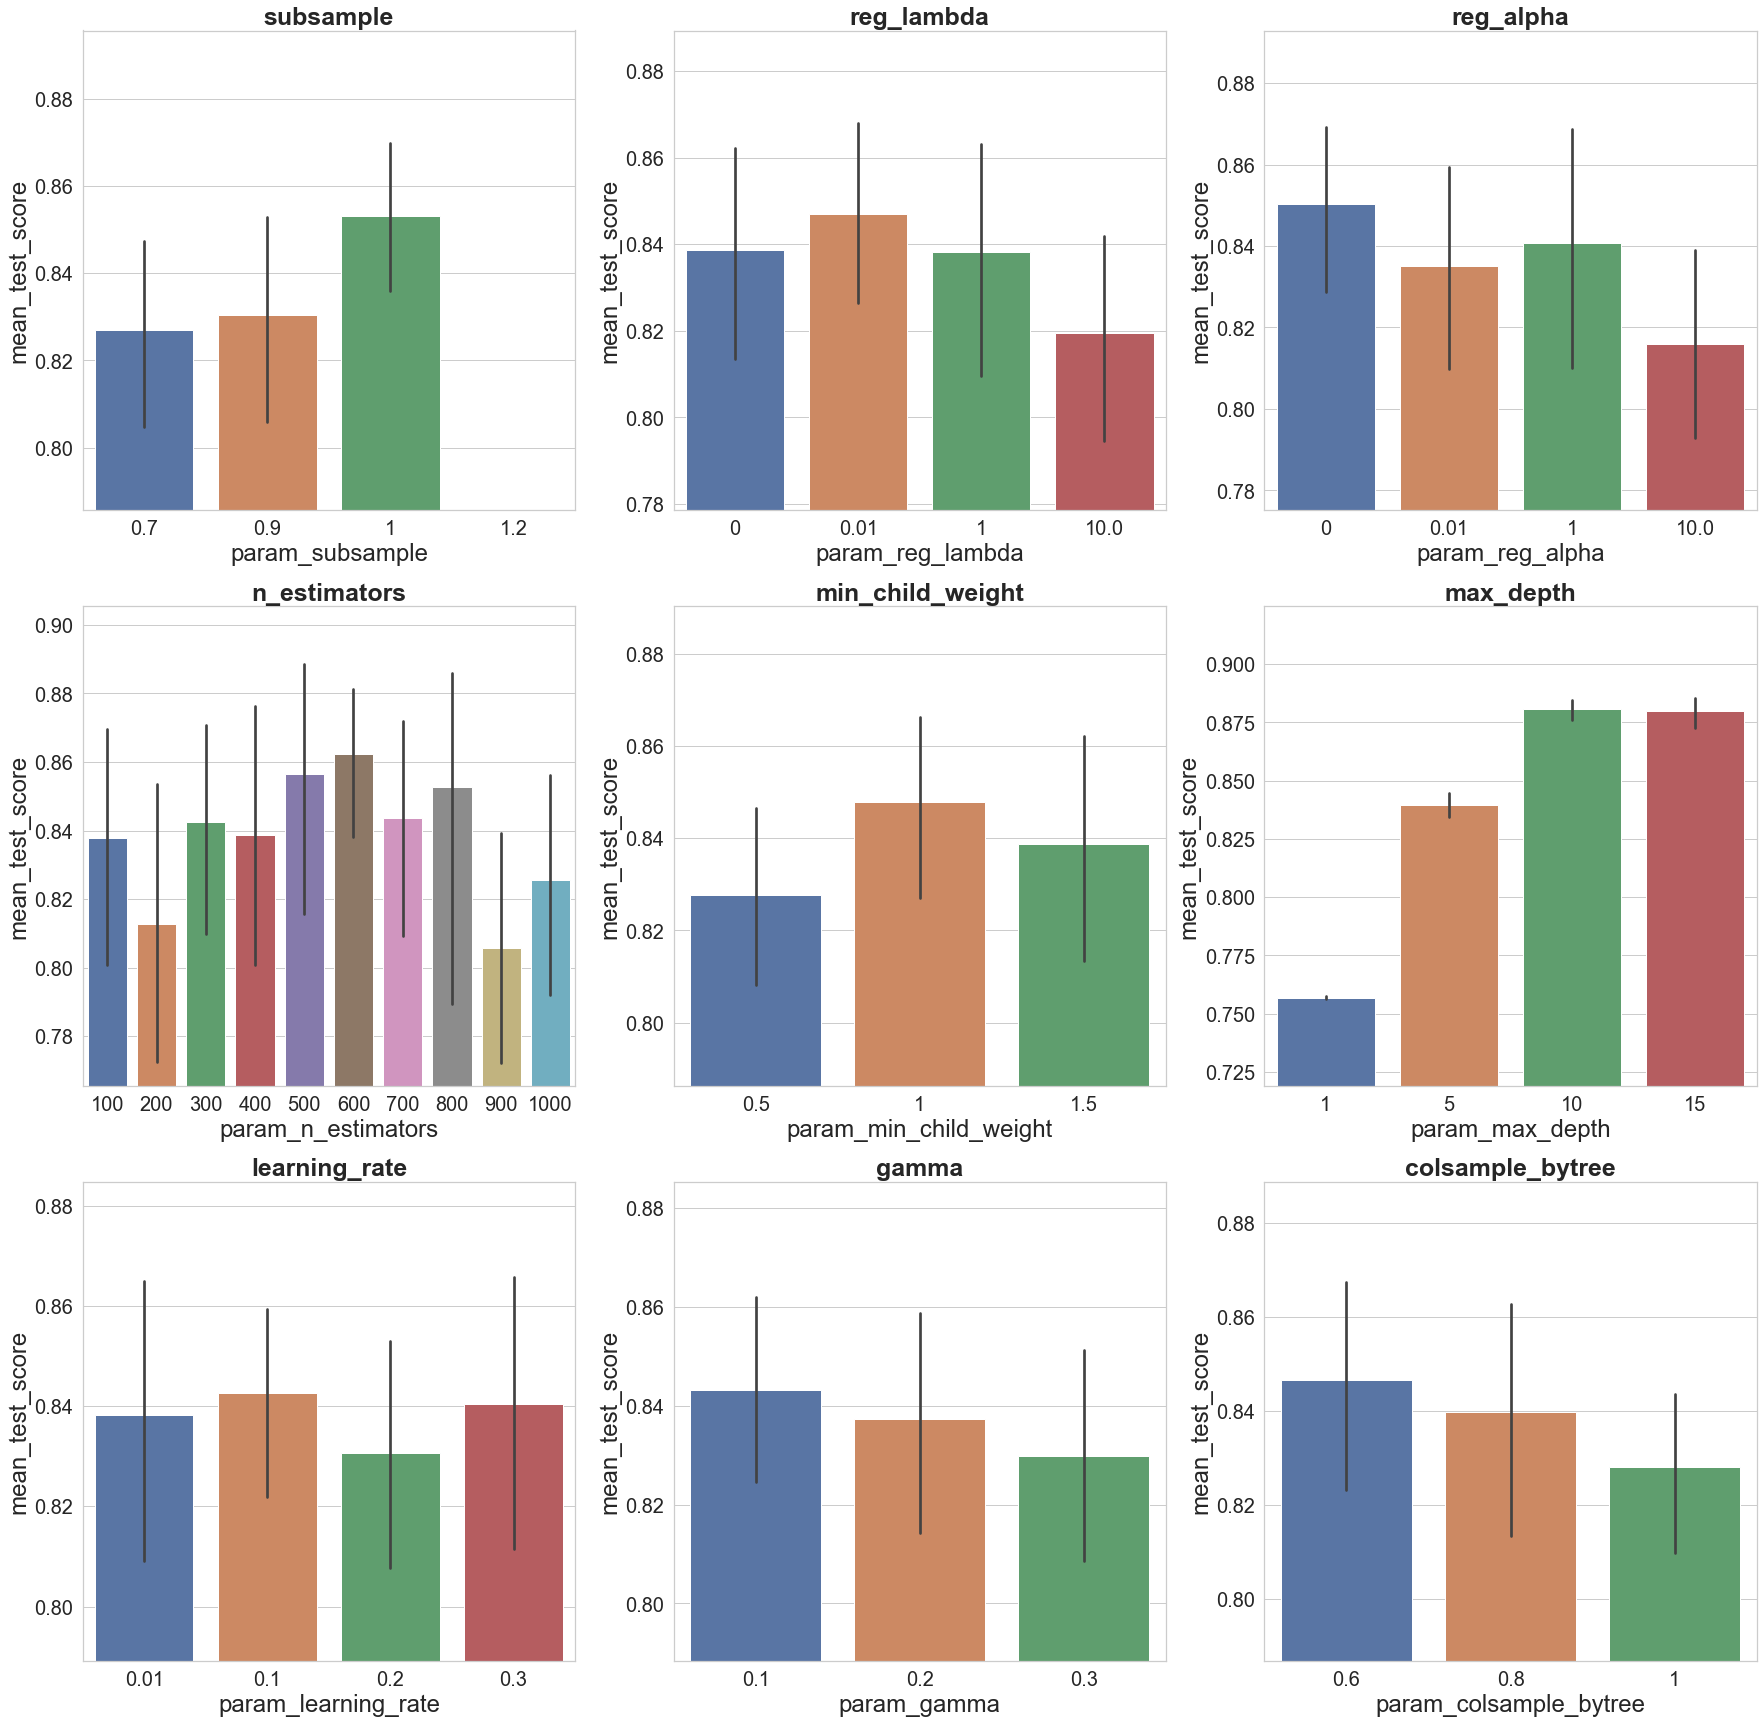

In [76]:
xgb_param_grid_1 = {'n_estimators': [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)],
              'learning_rate': [0.01, 0.1, 0.2, 0.3],
              'max_depth': [1, 5, 10, 15],
              'gamma': [0.1, 0.2, 0.3],
              'min_child_weight': [0.5, 1, 1.5],
              'subsample': [0.7, 0.9, 1, 1.2],
              'colsample_bytree': [0.6, 0.8, 1],
              'reg_alpha': [0, 1e-2, 1, 1e1],
              'reg_lambda': [0, 1e-2, 1, 1e1]}

raw_data.add_est('xgb', xgb.XGBRFClassifier())
raw_data.set_est_param_grid_1('xgb', xgb_param_grid_1)

raw_data.first_round_search('xgb', 100)

In [78]:
xgb_param_grid_2 = {'n_estimators': [638,],
              'learning_rate': [0.1,],
              'max_depth': [12,],
              'gamma': [0.1,],
              'min_child_weight': [1,],
              'subsample': [1,],
              'colsample_bytree': [0.4,],
              'reg_alpha': [0,],
              'reg_lambda': [0.01,]}

raw_data.set_est_param_grid_2('xgb', xgb_param_grid_2)
raw_data.second_round_search('xgb')

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  5.4min finished
C:\Users\Konstantin\.conda\envs\ml_hse\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[08:42:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy:  0.8938953488372093 

Confusion matrix: 
 [[  3   2   3   0]
 [  3  28  45   0]
 [  0   1 584   2]
 [  0   0  17   0]]


In [79]:
raw_data.get_est_info('xgb')

est: XGBRFClassifier(base_score=None, booster=None, colsample_bylevel=None,
                colsample_bytree=None, gamma=None, gpu_id=None,
                importance_type='gain', interaction_constraints=None,
                max_delta_step=None, max_depth=None, min_child_weight=None,
                missing=nan, monotone_constraints=None, n_estimators=100,
                n_jobs=None, num_parallel_tree=None,
                objective='binary:logistic', random_state=None, reg_alpha=None,
                scale_pos_weight=None, tree_method=None,
                validate_parameters=None, verbosity=None)
param_grid_1: {'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000], 'learning_rate': [0.01, 0.1, 0.2, 0.3], 'max_depth': [1, 5, 10, 15], 'gamma': [0.1, 0.2, 0.3], 'min_child_weight': [0.5, 1, 1.5], 'subsample': [0.7, 0.9, 1, 1.2], 'colsample_bytree': [0.6, 0.8, 1], 'reg_alpha': [0, 0.01, 1, 10.0], 'reg_lambda': [0, 0.01, 1, 10.0]}
param_grid_2: {'n_estimators': [638], 'lear

### SVM

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed: 18.6min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 27.6min finished
C:\Users\Konstantin\.conda\envs\ml_hse\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


SVC(C=100, decision_function_shape='ovo', gamma=0.0001, max_iter=10000)

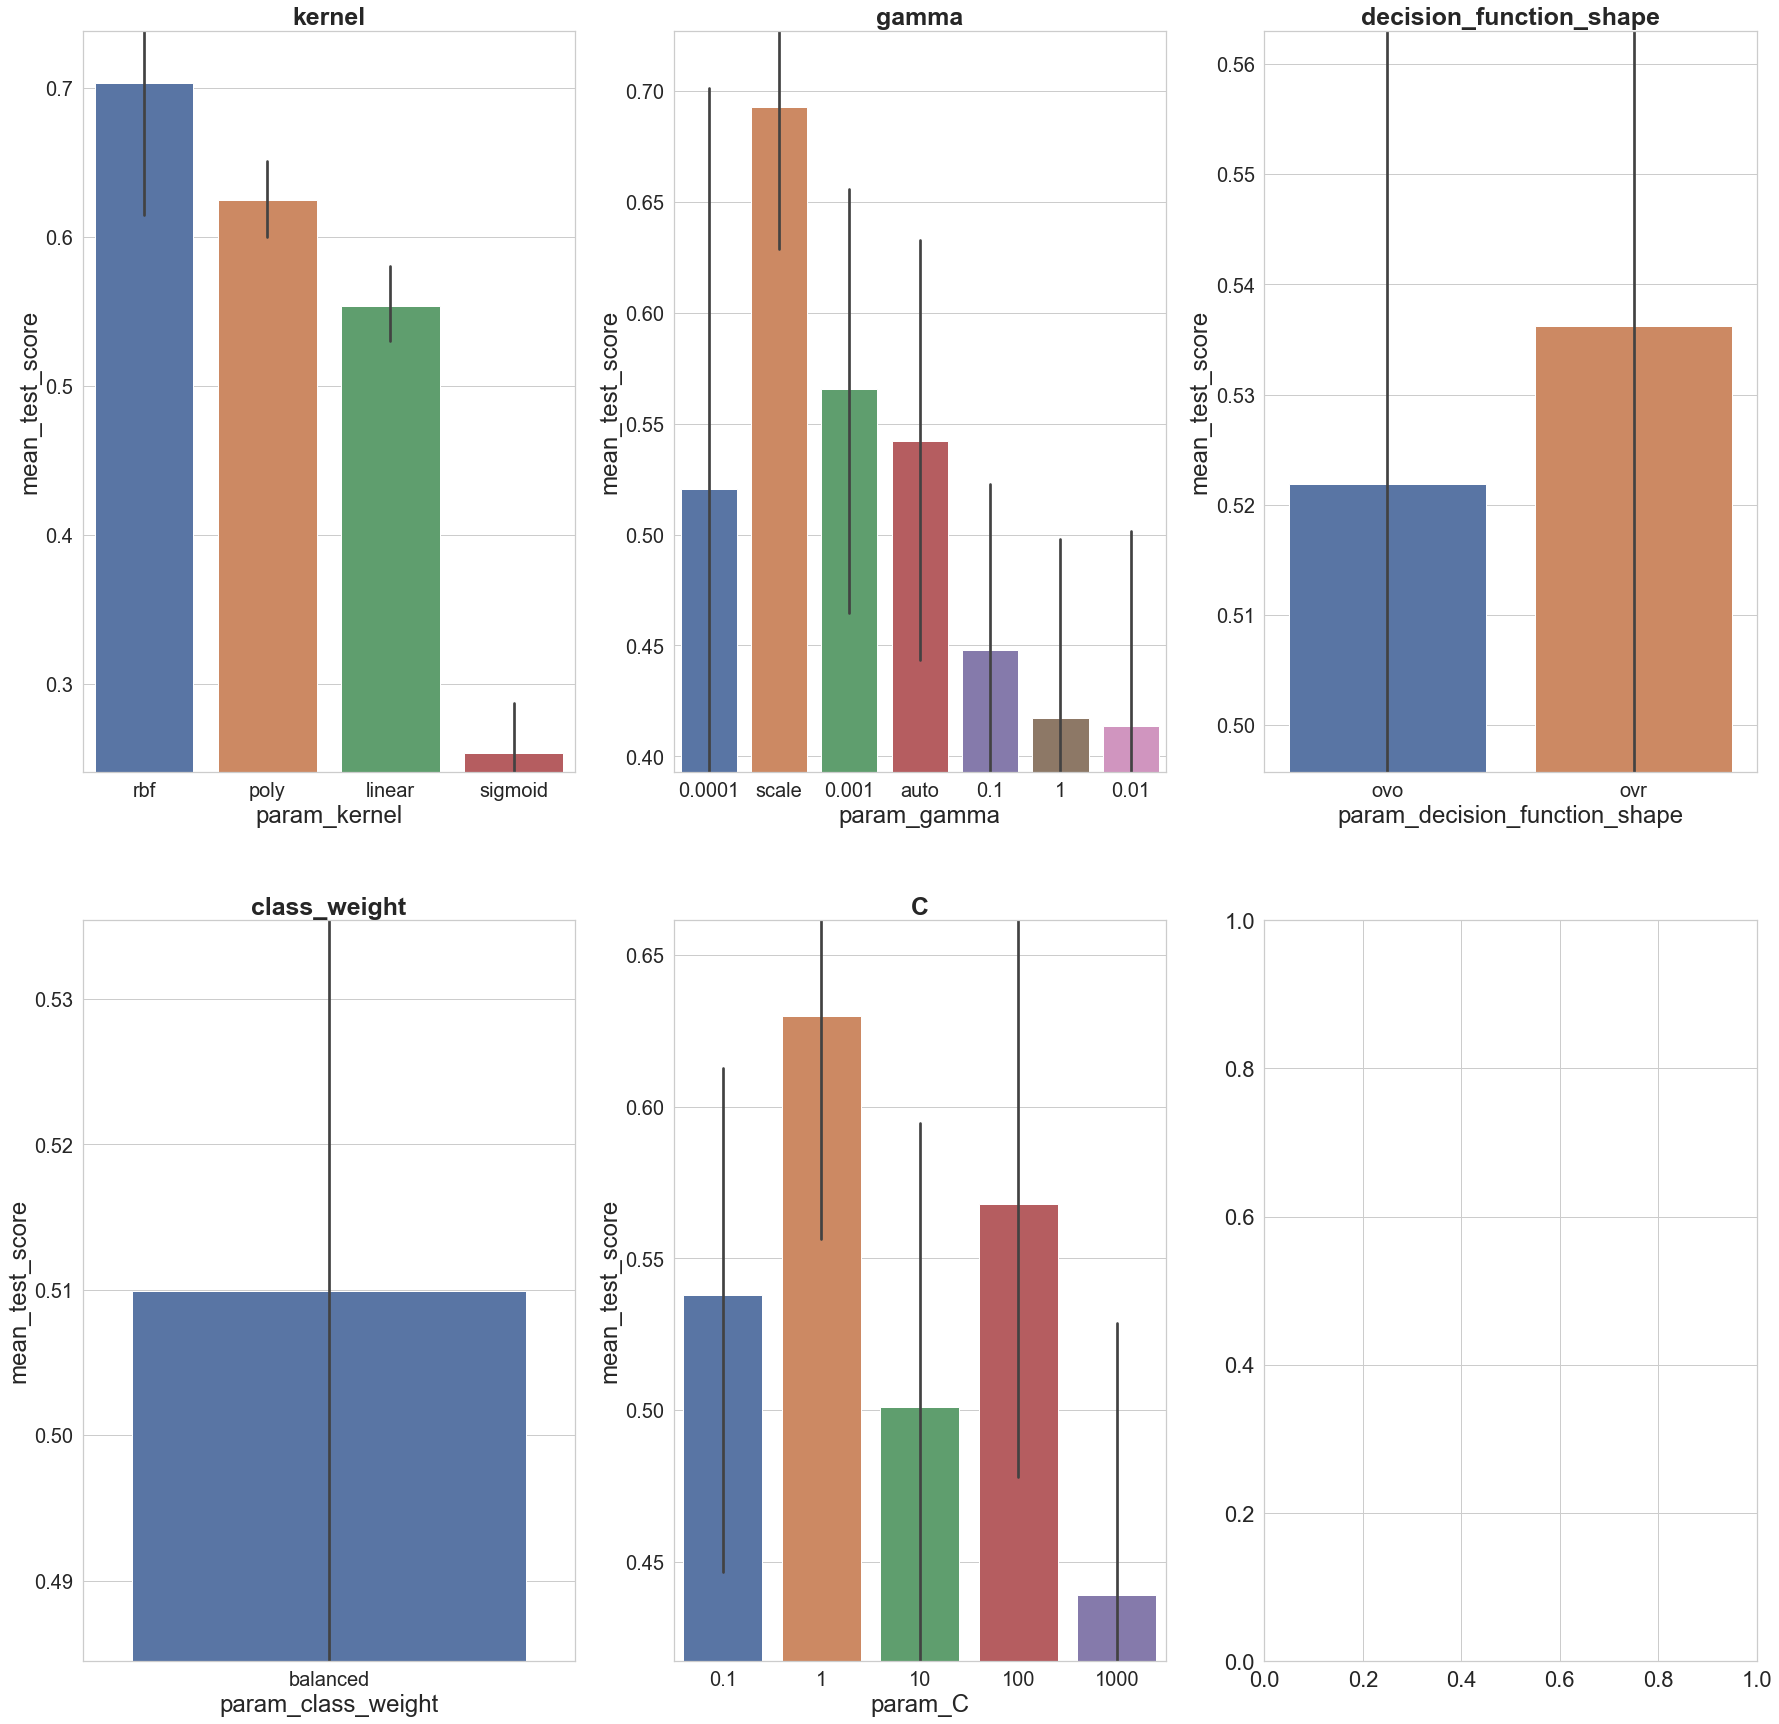

In [80]:
svm_param_grid_1 = {'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
              'C': [0.1, 1, 10, 100, 1000],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001, 'scale', 'auto'],
              'class_weight': [None, 'balanced'],
              'decision_function_shape': ['ovr', 'ovo']}

raw_data.add_est('svm', SVC(max_iter=10000))
raw_data.set_est_param_grid_1('svm', svm_param_grid_1)

raw_data.first_round_search('svm', 100)

In [81]:
svm_param_grid_2 = {'kernel': ['rbf',],
              'C': [4, 6, 5],
              'gamma': ['scale', ],
              'class_weight': ['balanced', None],
              'decision_function_shape': ['ovr',]}

raw_data.set_est_param_grid_2('svm', svm_param_grid_2)
raw_data.second_round_search('svm')

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 out of  18 | elapsed:  2.0min remaining:   33.5s
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:  2.0min finished


Accuracy:  0.8633720930232558 

Confusion matrix: 
 [[  2   2   4   0]
 [  4   7  65   0]
 [  0   2 585   0]
 [  0   0  17   0]]


In [82]:
raw_data.get_est_info('svm')

est: SVC(max_iter=10000)
param_grid_1: {'kernel': ['linear', 'poly', 'rbf', 'sigmoid'], 'C': [0.1, 1, 10, 100, 1000], 'gamma': [1, 0.1, 0.01, 0.001, 0.0001, 'scale', 'auto'], 'class_weight': [None, 'balanced'], 'decision_function_shape': ['ovr', 'ovo']}
param_grid_2: {'kernel': ['rbf'], 'C': [4, 6, 5], 'gamma': ['scale'], 'class_weight': ['balanced', None], 'decision_function_shape': ['ovr']}
train_acc: 0.819128457544901
best_params: {'C': 6, 'class_weight': None, 'decision_function_shape': 'ovr', 'gamma': 'scale', 'kernel': 'rbf'}
best_est: SVC(C=6, max_iter=10000)
test_acc: 0.8633720930232558
confusion_matrix: [[  2   2   4   0]
 [  4   7  65   0]
 [  0   2 585   0]
 [  0   0  17   0]]
svm_pred_y: [4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 3 4 4 4 4 4 3 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 3 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4

### Предобученный W2V

In [83]:
import gensim.downloader as api

In [84]:
w2v_model = api.load("fasttext-wiki-news-subwords-300")

[===-----------------------------------------------] 7.5% 71.8/958.4MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[=====---------------------------------------------] 10.6% 101.2/958.4MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[======--------------------------------------------] 13.7% 131.2/958.4MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[========------------------------------------------] 17.0% 162.9/958.4MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[==========----------------------------------------] 20.1% 192.8/958.4MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[===========---------------------------------------] 23.2% 222.5/958.4MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[=============-------------------------------------] 26.1% 249.9/958.4MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[==============------------------------------------] 29.5% 282.8/958.4MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[================----------------------------------] 32.8% 314.0/958.4MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[==================--------------------------------] 36.2% 347.4/958.4MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[===================-------------------------------] 39.7% 380.6/958.4MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[=====================-----------------------------] 43.1% 413.1/958.4MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[=======================---------------------------] 46.4% 444.5/958.4MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[========================--------------------------] 49.7% 475.9/958.4MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[===========================-----------------------] 55.5% 532.0/958.4MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[=============================---------------------] 58.9% 564.9/958.4MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[===============================-------------------] 62.3% 597.3/958.4MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[================================------------------] 65.8% 630.8/958.4MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[==================================----------------] 69.4% 665.1/958.4MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[====================================--------------] 72.6% 695.6/958.4MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[======================================------------] 76.0% 728.8/958.4MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[=======================================-----------] 79.3% 759.8/958.4MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[=========================================---------] 82.6% 792.0/958.4MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[==========================================--------] 85.7% 821.2/958.4MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[============================================------] 89.1% 854.1/958.4MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[==============================================----] 93.5% 895.9/958.4MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[================================================--] 96.7% 926.6/958.4MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[=================================================-] 99.8% 956.5/958.4MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [87]:
len(w2v_model.wv.index2word)

<ipython-input-87-bef865e11ddd>:1: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  len(w2v_model.wv.index2word)


999999

In [89]:
with shelve.open('data\\w2v_wiki', flag='n') as w2v_file:
    w2v_file['w2v'] = w2v_model

In [90]:
raw_data = Results(df_gen,
              test_x,
              test_y,
              'data\\w2v_wiki')

<ipython-input-88-f9f88ccc7358>:12: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  self.index2word_set = set(self.w2v.wv.index2word)


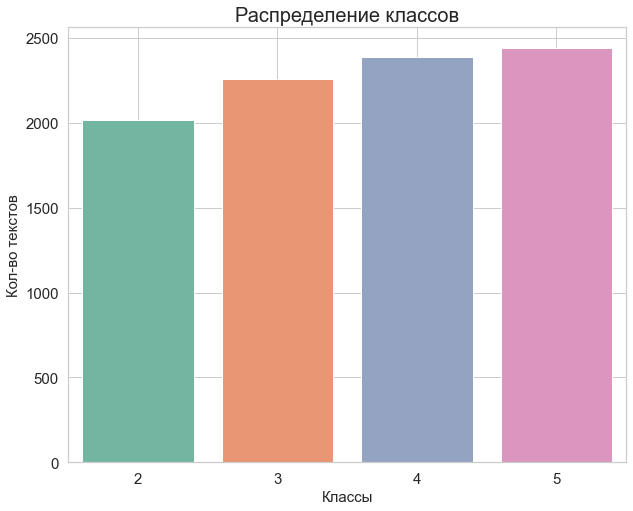

In [91]:
raw_data.show_train_data()

### knn

C:\Users\Konstantin\.conda\envs\ml_hse\lib\site-packages\sklearn\model_selection\_search.py:278: UserWarning: The total space of parameters 80 is smaller than n_iter=100. Running 80 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 3 folds for each of 80 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:  3.2min finished


KNeighborsClassifier(n_neighbors=6, p=1, weights='distance')

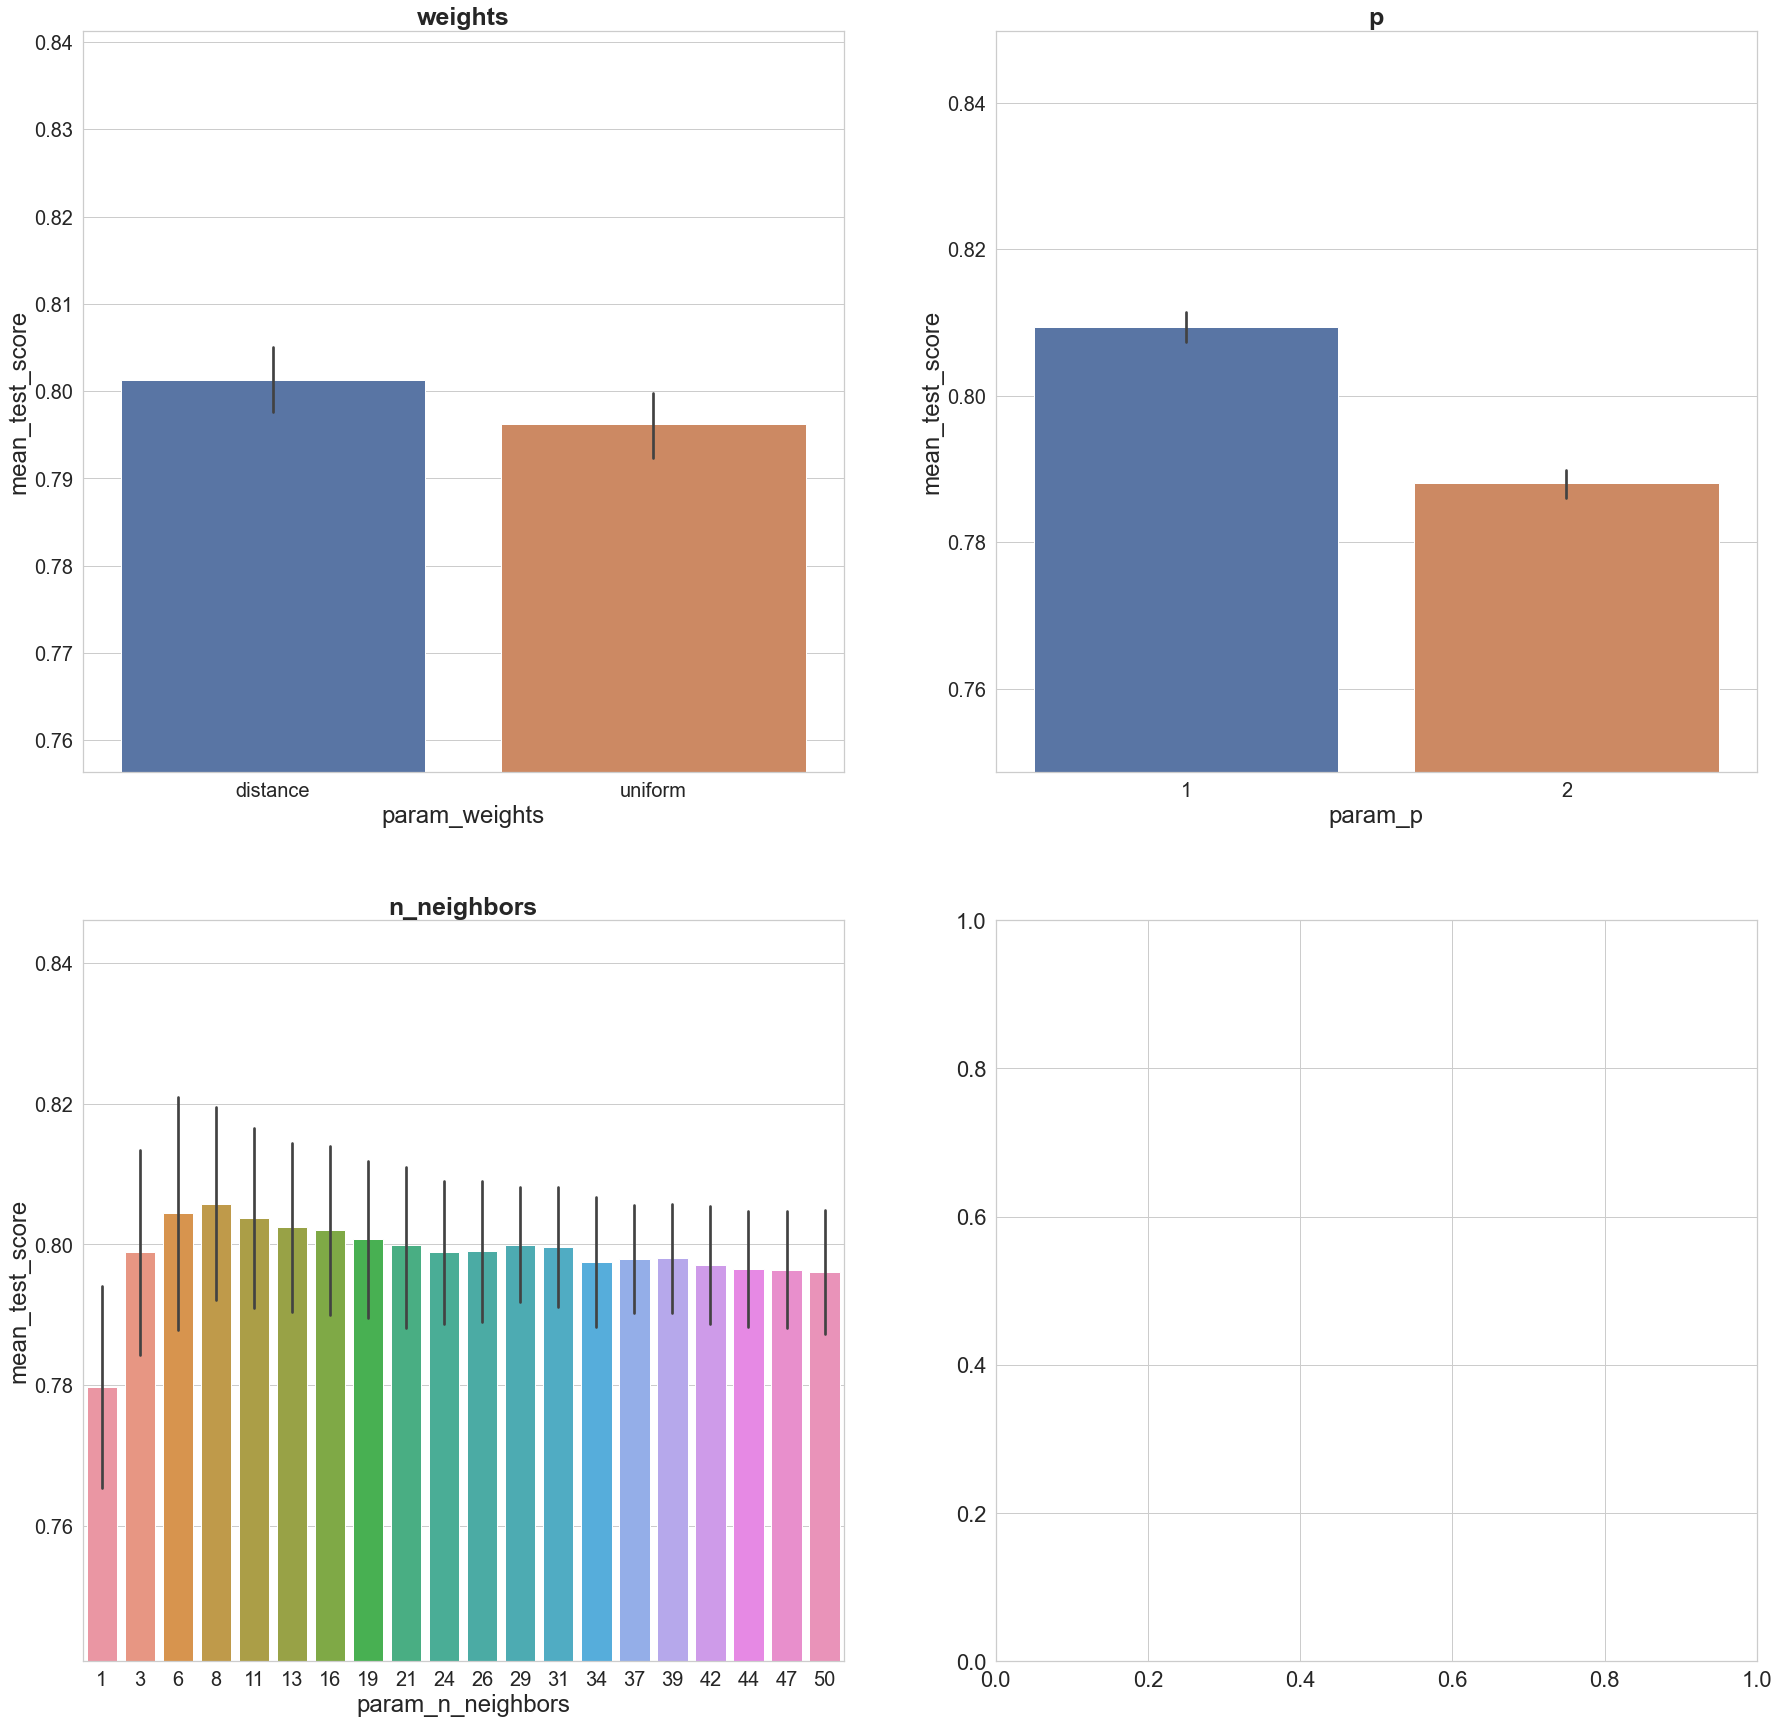

In [92]:
knn_param_grid_1 = {'n_neighbors': [int(x) for x in np.linspace(start = 1, stop = 50, num = 20)],
              'p': [1, 2],
              'weights': ['uniform', 'distance']}

raw_data.add_est('knn', KNeighborsClassifier(metric='minkowski', algorithm='auto'))
raw_data.set_est_param_grid_1('knn', knn_param_grid_1)

raw_data.first_round_search('knn', 100)

In [93]:
knn_param_grid_2 = {'n_neighbors': [7, 8, 9,],
              'p': [1,],
              'weights': ['distance',]}

raw_data.set_est_param_grid_2('knn', knn_param_grid_2)

In [94]:
raw_data.second_round_search('knn')

Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of   9 | elapsed:    6.1s remaining:    3.0s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:    6.2s finished


Accuracy:  0.9113372093023255 

Confusion matrix: 
 [[  3   1   4   0]
 [  5  38  33   0]
 [  0   5 581   1]
 [  0   0  12   5]]


In [95]:
raw_data.get_est_info('knn')

est: KNeighborsClassifier()
param_grid_1: {'n_neighbors': [1, 3, 6, 8, 11, 13, 16, 19, 21, 24, 26, 29, 31, 34, 37, 39, 42, 44, 47, 50], 'p': [1, 2], 'weights': ['uniform', 'distance']}
param_grid_2: {'n_neighbors': [7, 8, 9], 'p': [1], 'weights': ['distance']}
train_acc: 0.8215462332130206
best_params: {'n_neighbors': 8, 'p': 1, 'weights': 'distance'}
best_est: KNeighborsClassifier(n_neighbors=8, p=1, weights='distance')
test_acc: 0.9113372093023255
confusion_matrix: [[  3   1   4   0]
 [  5  38  33   0]
 [  0   5 581   1]
 [  0   0  12   5]]
knn_pred_y: [4 4 4 4 4 3 4 4 4 4 4 4 4 4 4 4 4 4 4 3 4 4 4 3 4 3 4 4 4 4 4 3 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 3 4 4 4 4 4 4 4 4 4 4 3 4 4 4 4 4 4 3 4 4 4 4 4 4
 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 3 4 4 4 4 4 4 4 4 4 2 4 4 4 4 4 4 5 4 4 4 3 4 4 4 4 4 4 4 3
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 3 4 4 4 4 4 4 4 4 4 4 4 4 4 5 4 4 4 2

### RandomForest

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed: 11.0min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 17.8min finished


RandomForestClassifier(bootstrap=False, max_depth=30, max_features='log2',
                       min_samples_leaf=2, min_samples_split=8,
                       n_estimators=1000)

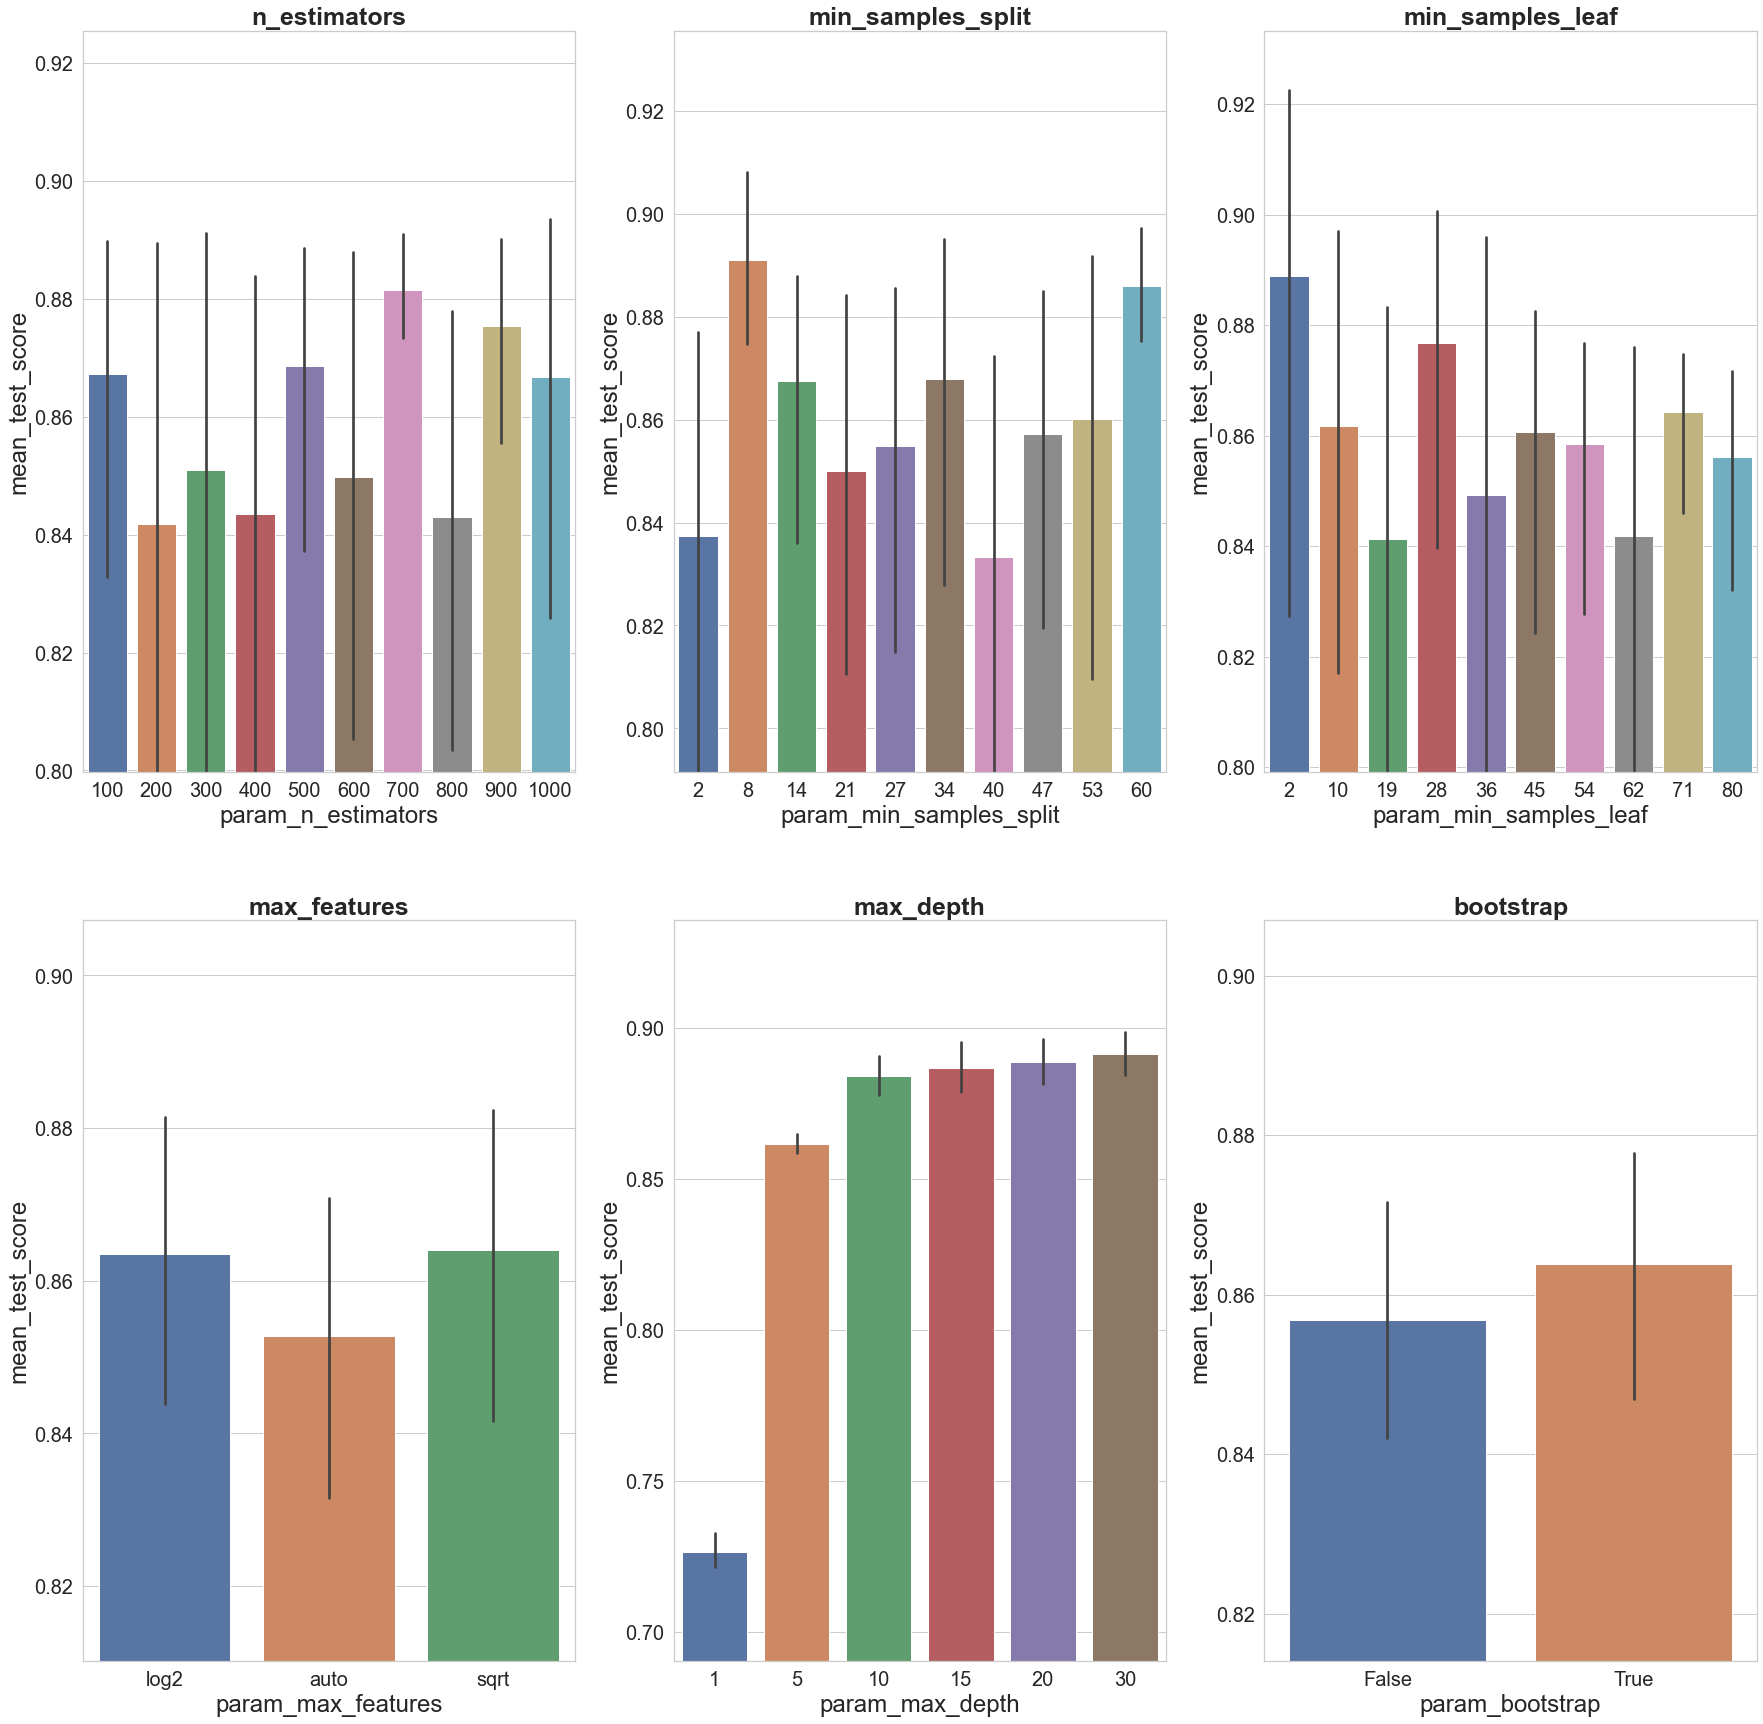

In [99]:
rf_param_grid_1 = {'n_estimators': [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)],
              'max_features': ['auto', 'log2', 'sqrt'],
              'max_depth': [1, 5, 10, 15, 20, 30],
              'min_samples_split': [int(x) for x in np.linspace(start = 2, stop = 60, num = 10)],
              'min_samples_leaf': [int(x) for x in np.linspace(start = 2, stop = 80, num = 10)],
              'bootstrap': [True, False]}

raw_data.add_est('rf', RandomForestClassifier())
raw_data.set_est_param_grid_1('rf', rf_param_grid_1)

raw_data.first_round_search('rf', 100)

In [100]:
rf_param_grid_2 = {'n_estimators': [int(x) for x in np.linspace(start = 680, stop = 780, num = 10)],
              'max_features': ['sqrt',],
              'max_depth': [29, 30, 31, 32, 33],
              'min_samples_split': [6, 7, 8],
              'min_samples_leaf': [1, 2, 3, 4],
              'bootstrap': [True,]}

raw_data.set_est_param_grid_2('rf', rf_param_grid_2)
raw_data.second_round_search('rf')

Fitting 3 folds for each of 600 candidates, totalling 1800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed: 21.2min
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed: 48.6min
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed: 87.1min
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed: 136.4min
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed: 195.9min
[Parallel(n_jobs=-1)]: Done 1800 out of 1800 | elapsed: 198.1min finished


Accuracy:  0.9127906976744186 

Confusion matrix: 
 [[  3   1   4   0]
 [  2  40  34   0]
 [  0   1 584   2]
 [  0   0  16   1]]


In [101]:
raw_data.get_est_info('rf')

est: RandomForestClassifier()
param_grid_1: {'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000], 'max_features': ['auto', 'log2', 'sqrt'], 'max_depth': [1, 5, 10, 15, 20, 30], 'min_samples_split': [2, 8, 14, 21, 27, 34, 40, 47, 53, 60], 'min_samples_leaf': [2, 10, 19, 28, 36, 45, 54, 62, 71, 80], 'bootstrap': [True, False]}
param_grid_2: {'n_estimators': [680, 691, 702, 713, 724, 735, 746, 757, 768, 780], 'max_features': ['sqrt'], 'max_depth': [29, 30, 31, 32, 33], 'min_samples_split': [6, 7, 8], 'min_samples_leaf': [1, 2, 3, 4], 'bootstrap': [True]}
train_acc: 0.9257247766692652
best_params: {'bootstrap': True, 'max_depth': 33, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 6, 'n_estimators': 680}
best_est: RandomForestClassifier(max_depth=33, max_features='sqrt', min_samples_split=6,
                       n_estimators=680)
test_acc: 0.9127906976744186
confusion_matrix: [[  3   1   4   0]
 [  2  40  34   0]
 [  0   1 584   2]
 [  0   0  16   1]]


### XGBoost

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed: 42.1min
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed: 183.5min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 289.6min finished
C:\Users\Konstantin\.conda\envs\ml_hse\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[04:59:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBRFClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                colsample_bytree=0.6, gamma=0.1, gpu_id=-1,
                importance_type='gain', interaction_constraints='',
                learning_rate=0.01, max_delta_step=0, max_depth=15,
                min_child_weight=1, missing=nan, monotone_constraints='()',
                n_estimators=300, n_jobs=12, num_parallel_tree=300,
                objective='multi:softprob', random_state=0, reg_alpha=0.01,
                reg_lambda=0.01, scale_pos_weight=None, subsample=1,
                tree_method='exact', validate_parameters=1, verbosity=None)

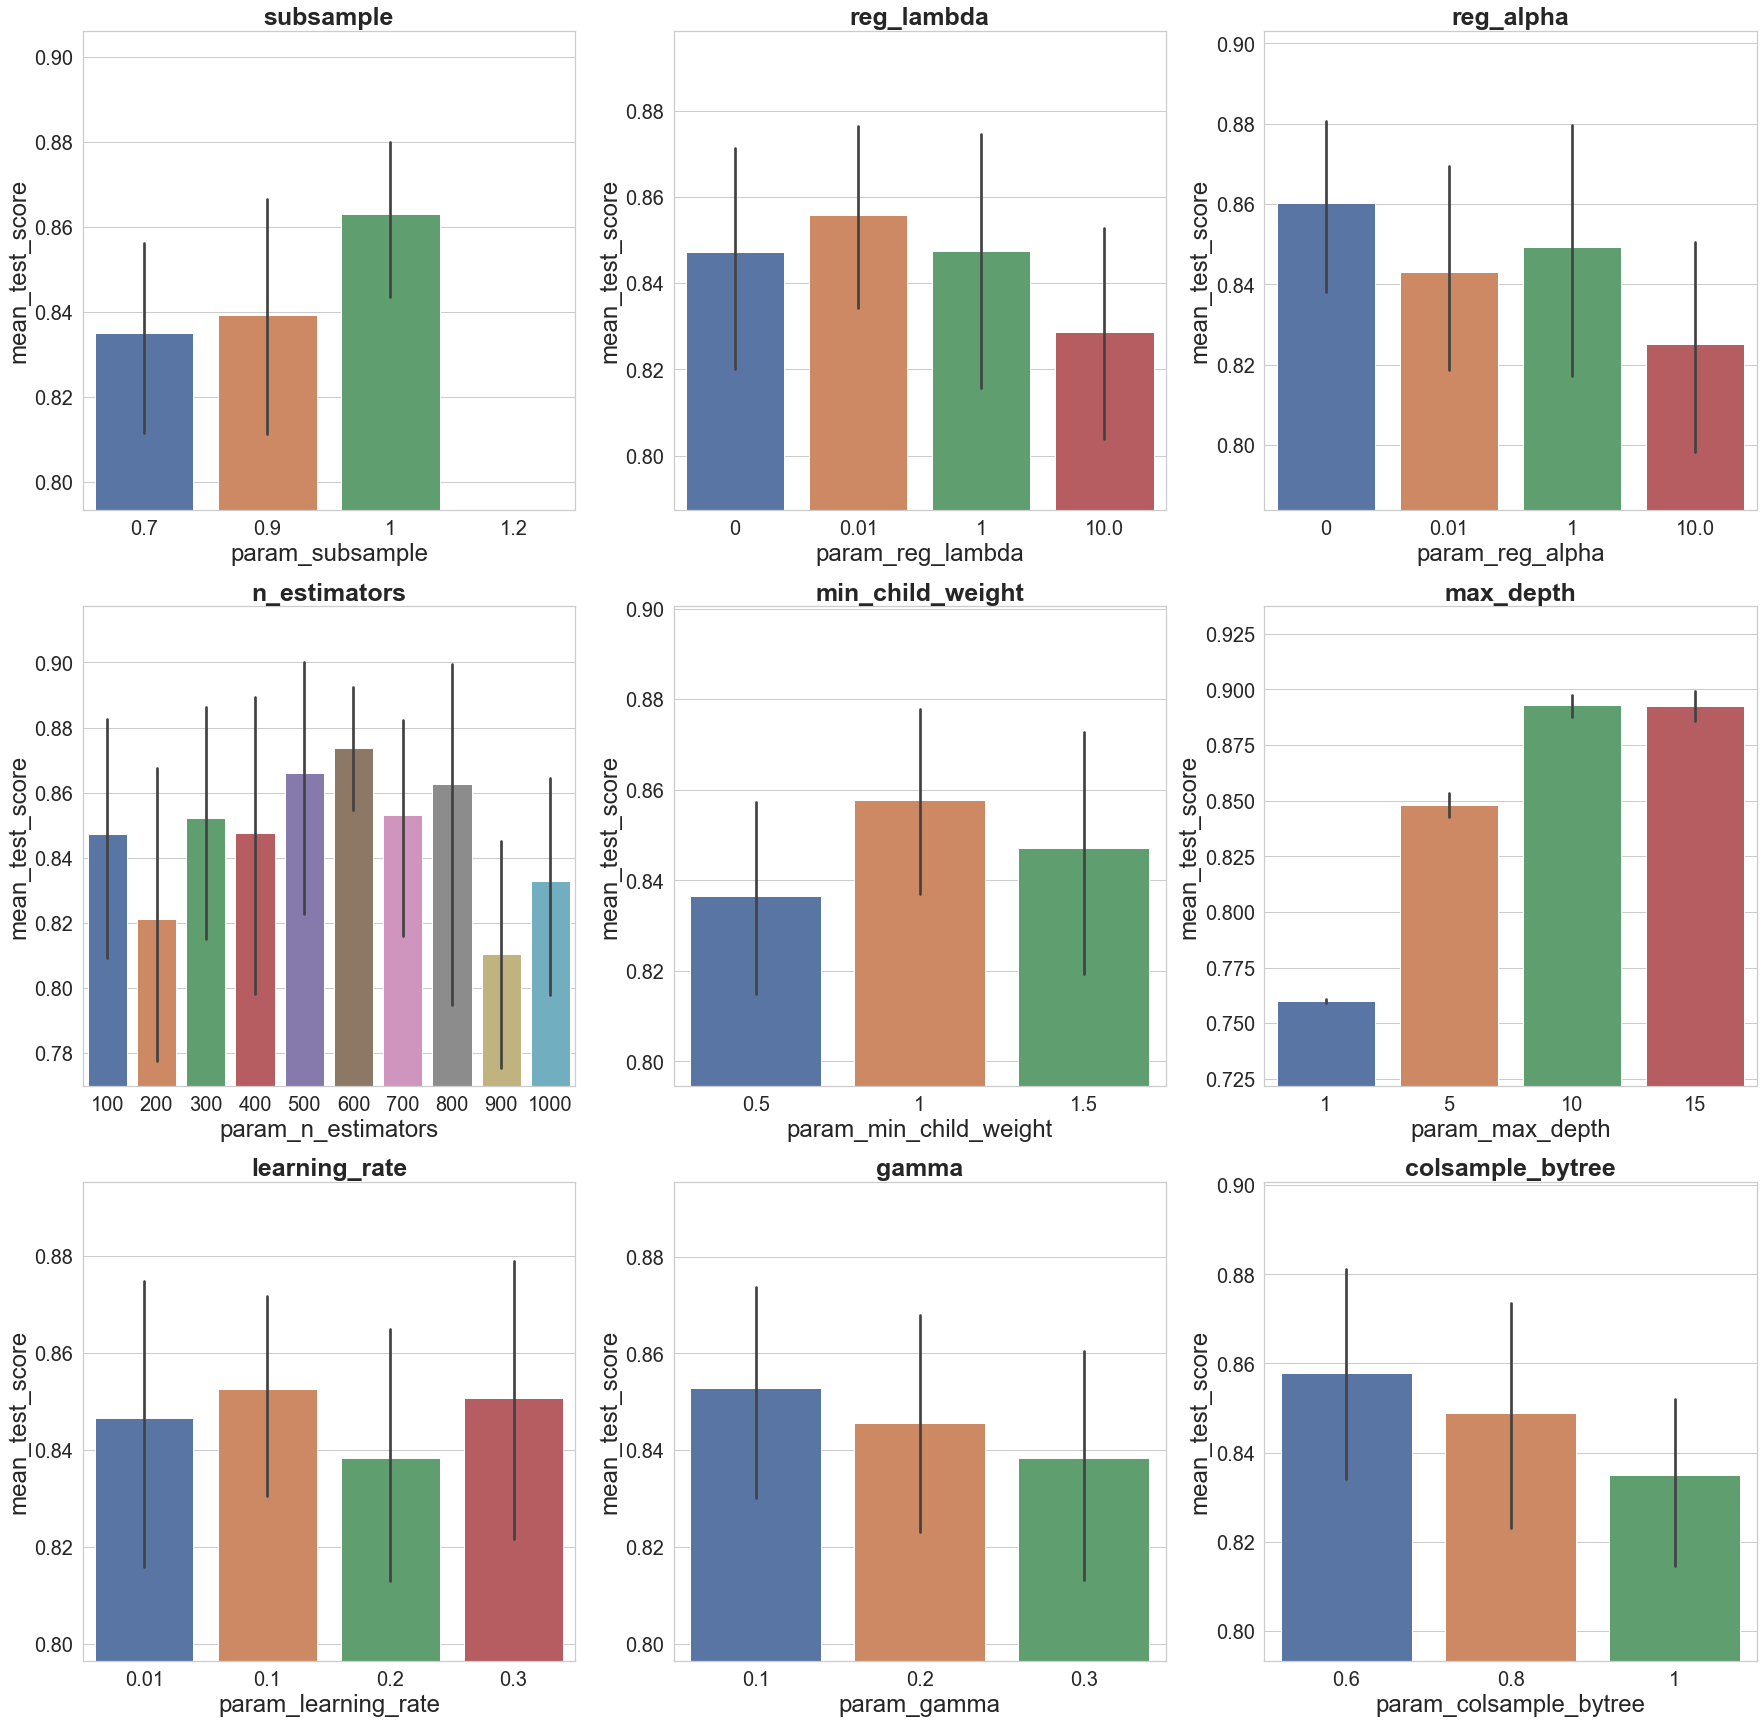

In [102]:
xgb_param_grid_1 = {'n_estimators': [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)],
              'learning_rate': [0.01, 0.1, 0.2, 0.3],
              'max_depth': [1, 5, 10, 15],
              'gamma': [0.1, 0.2, 0.3],
              'min_child_weight': [0.5, 1, 1.5],
              'subsample': [0.7, 0.9, 1, 1.2],
              'colsample_bytree': [0.6, 0.8, 1],
              'reg_alpha': [0, 1e-2, 1, 1e1],
              'reg_lambda': [0, 1e-2, 1, 1e1]}

raw_data.add_est('xgb', xgb.XGBRFClassifier())
raw_data.set_est_param_grid_1('xgb', xgb_param_grid_1)

raw_data.first_round_search('xgb', 100)

In [103]:
xgb_param_grid_2 = {'n_estimators': [638,],
              'learning_rate': [0.1,],
              'max_depth': [12,],
              'gamma': [0.1,],
              'min_child_weight': [1,],
              'subsample': [1,],
              'colsample_bytree': [0.4,],
              'reg_alpha': [0,],
              'reg_lambda': [0.01,]}

raw_data.set_est_param_grid_2('xgb', xgb_param_grid_2)
raw_data.second_round_search('xgb')

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  4.9min finished
C:\Users\Konstantin\.conda\envs\ml_hse\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[05:08:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy:  0.8924418604651163 

Confusion matrix: 
 [[  3   1   4   0]
 [  2  26  48   0]
 [  0   0 585   2]
 [  0   0  17   0]]


In [104]:
raw_data.get_est_info('xgb')

est: XGBRFClassifier(base_score=None, booster=None, colsample_bylevel=None,
                colsample_bytree=None, gamma=None, gpu_id=None,
                importance_type='gain', interaction_constraints=None,
                max_delta_step=None, max_depth=None, min_child_weight=None,
                missing=nan, monotone_constraints=None, n_estimators=100,
                n_jobs=None, num_parallel_tree=None,
                objective='binary:logistic', random_state=None, reg_alpha=None,
                scale_pos_weight=None, tree_method=None,
                validate_parameters=None, verbosity=None)
param_grid_1: {'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000], 'learning_rate': [0.01, 0.1, 0.2, 0.3], 'max_depth': [1, 5, 10, 15], 'gamma': [0.1, 0.2, 0.3], 'min_child_weight': [0.5, 1, 1.5], 'subsample': [0.7, 0.9, 1, 1.2], 'colsample_bytree': [0.6, 0.8, 1], 'reg_alpha': [0, 0.01, 1, 10.0], 'reg_lambda': [0, 0.01, 1, 10.0]}
param_grid_2: {'n_estimators': [638], 'lear

### SVM

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed: 18.9min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 27.9min finished
C:\Users\Konstantin\.conda\envs\ml_hse\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


SVC(C=100, decision_function_shape='ovo', gamma=0.0001, max_iter=10000)

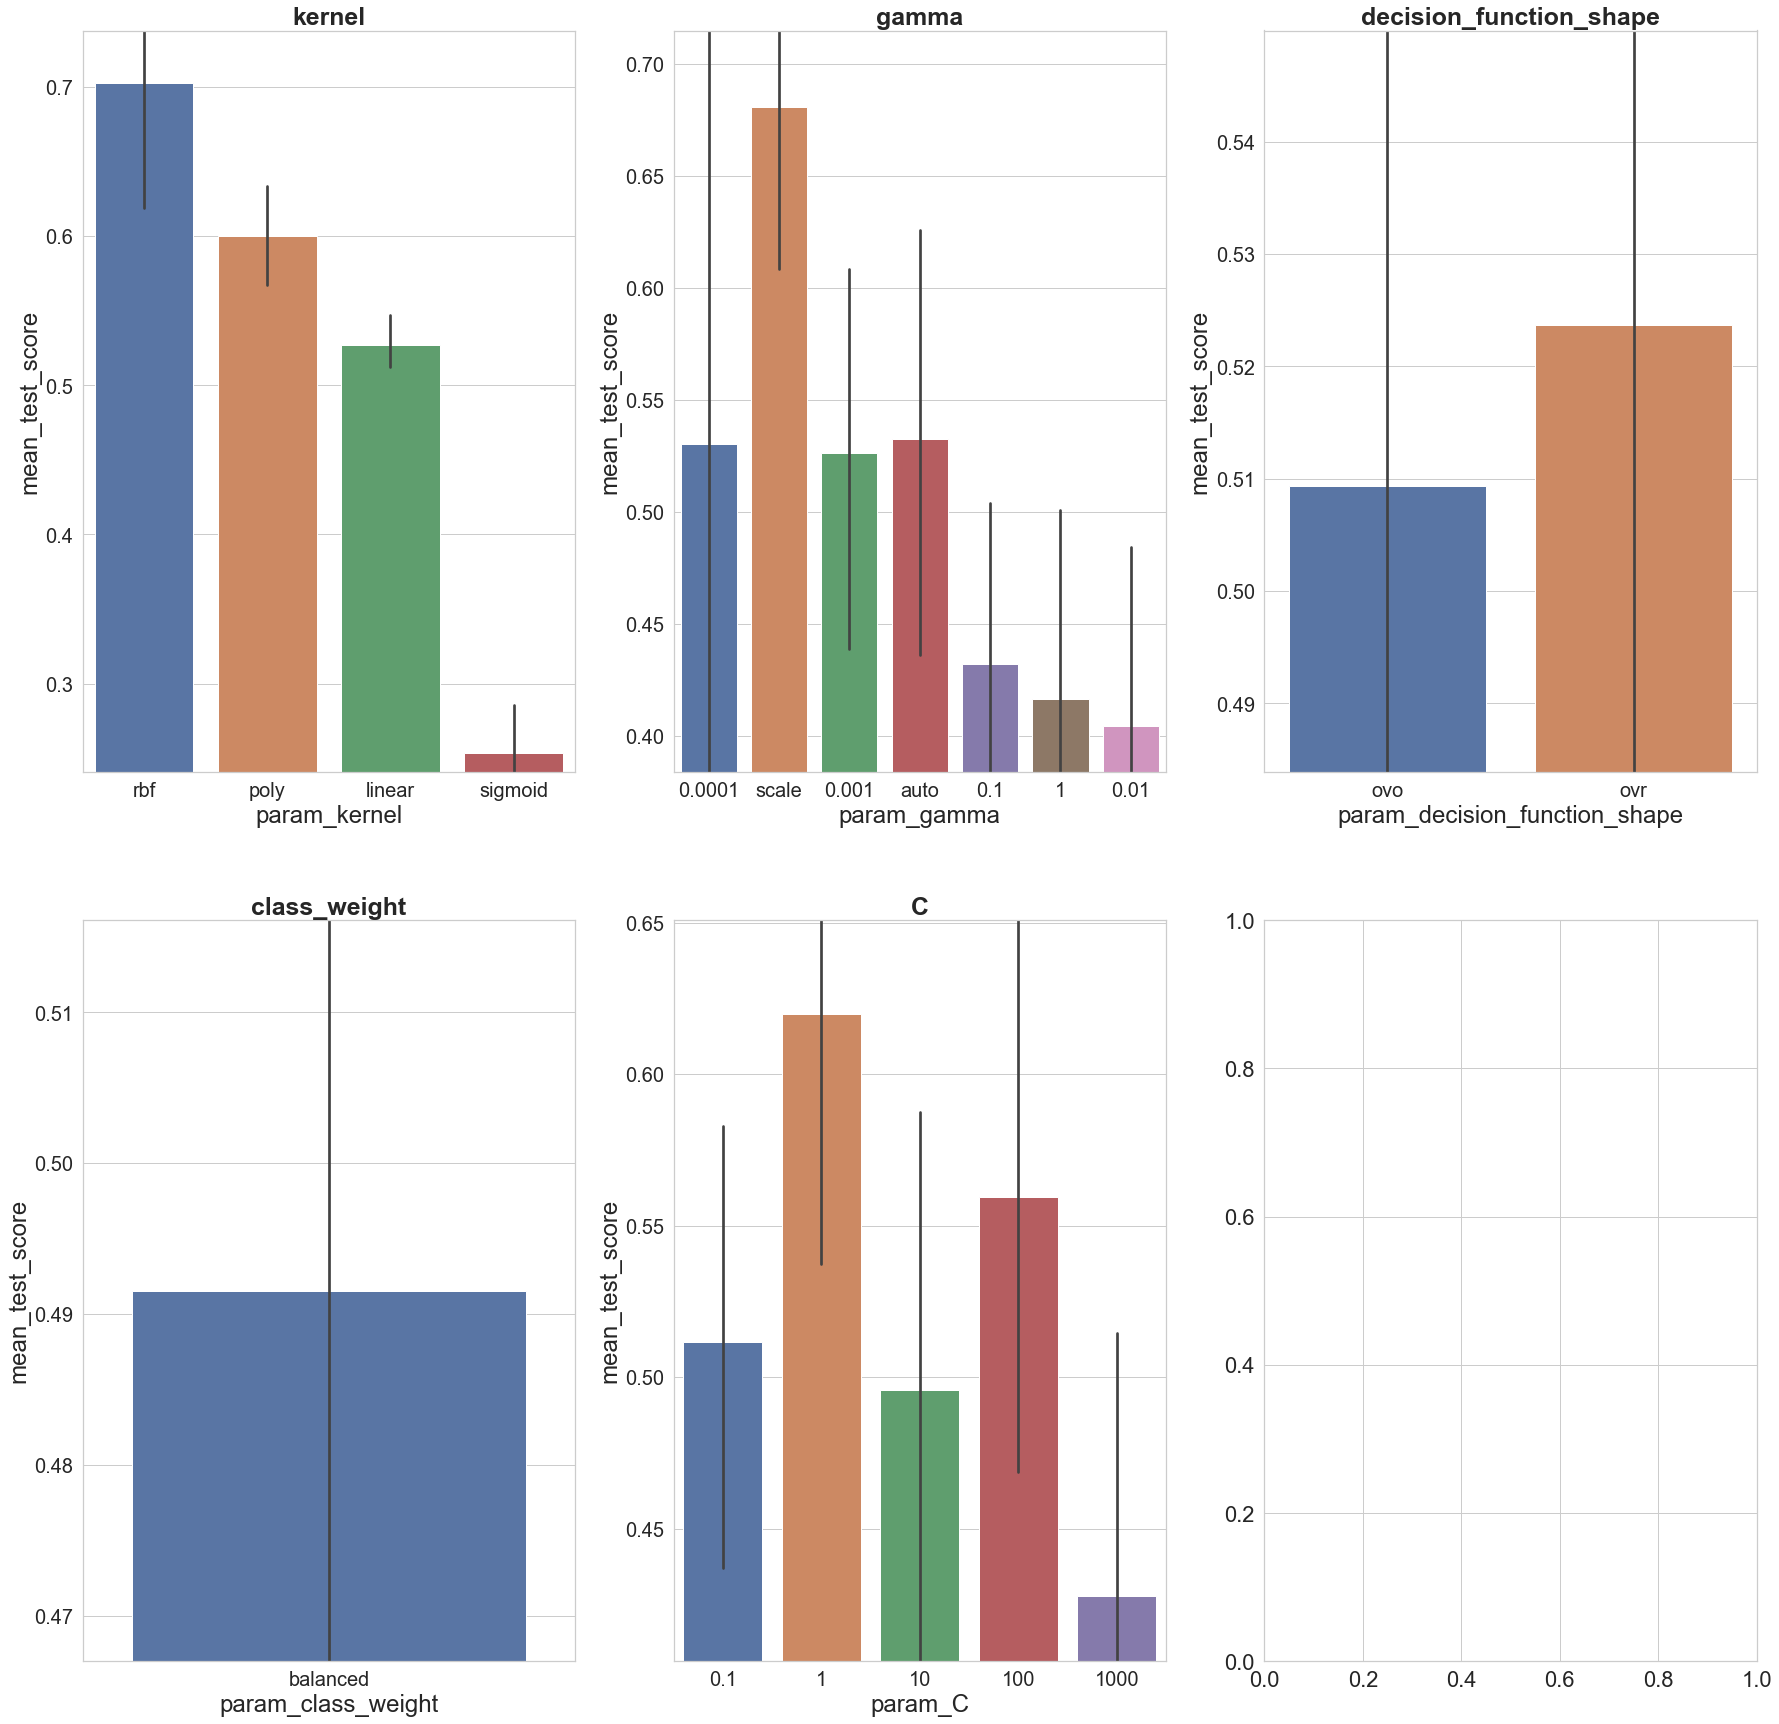

In [105]:
svm_param_grid_1 = {'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
              'C': [0.1, 1, 10, 100, 1000],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001, 'scale', 'auto'],
              'class_weight': [None, 'balanced'],
              'decision_function_shape': ['ovr', 'ovo']}

raw_data.add_est('svm', SVC(max_iter=10000))
raw_data.set_est_param_grid_1('svm', svm_param_grid_1)

raw_data.first_round_search('svm', 100)

In [106]:
svm_param_grid_2 = {'kernel': ['rbf',],
              'C': [4, 6, 5],
              'gamma': ['scale', ],
              'class_weight': ['balanced', None],
              'decision_function_shape': ['ovr',]}

raw_data.set_est_param_grid_2('svm', svm_param_grid_2)
raw_data.second_round_search('svm')

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 out of  18 | elapsed:   51.7s remaining:   14.7s
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:   55.0s finished


Accuracy:  0.8633720930232558 

Confusion matrix: 
 [[  2   2   4   0]
 [  4   7  65   0]
 [  0   2 585   0]
 [  0   0  17   0]]


In [107]:
raw_data.get_est_info('svm')

est: SVC(max_iter=10000)
param_grid_1: {'kernel': ['linear', 'poly', 'rbf', 'sigmoid'], 'C': [0.1, 1, 10, 100, 1000], 'gamma': [1, 0.1, 0.01, 0.001, 0.0001, 'scale', 'auto'], 'class_weight': [None, 'balanced'], 'decision_function_shape': ['ovr', 'ovo']}
param_grid_2: {'kernel': ['rbf'], 'C': [4, 6, 5], 'gamma': ['scale'], 'class_weight': ['balanced', None], 'decision_function_shape': ['ovr']}
train_acc: 0.8190185553578475
best_params: {'C': 6, 'class_weight': None, 'decision_function_shape': 'ovr', 'gamma': 'scale', 'kernel': 'rbf'}
best_est: SVC(C=6, max_iter=10000)
test_acc: 0.8633720930232558
confusion_matrix: [[  2   2   4   0]
 [  4   7  65   0]
 [  0   2 585   0]
 [  0   0  17   0]]
svm_pred_y: [4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 3 4 4 4 4 4 3 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 3 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 

In [108]:
raw_data.save_estimators('w2v_wiki_est')